









# Variant 5

# Imports

In [1]:
%matplotlib inline

import sys
import statsmodels as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Python & Library Versions

# Data

In [2]:
versions = ( ("matplotlib", matplotlib.__version__),
            ("numpy", np.__version__),
            ("pandas", pd.__version__),
            ("statsmodels", ss.__version__) )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 05:52:31) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)] 

library    version
------------------
matplotlib  3.0.2
numpy       1.18.5
pandas      1.1.3
statsmodels 0.12.0


# Data 

In [3]:
REGIONS = [
           ['PEN', 'Peninsula', 'Pmalay']]

In [4]:
production = pd.read_csv('data/production_good.csv')
rainfall = pd.read_csv('data/rainfall_good.csv')
area = pd.read_csv('data/area_good.csv')

In [5]:
RAINFALL_LAGS = [6, 7, 8, 9, 10, 11, 12]
PRODUCTION_LAGS = [6, 7, 8, 9, 10, 11, 12]

In [6]:
def process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS):
    output = {}
    for i, region in enumerate(REGIONS):
        data = production[production.Region == 'PEN']
        data = pd.merge(data[['Year', 'Month', 'Production', 'Diff_production']],
                        rainfall[rainfall.Region == 'Peninsula'][['Year', 'Month', 'Rainfall']], 
                        on=['Year', 'Month'], how='left')

        data = pd.merge(data, area[area.Region == 'Pmalay'][
            ['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')
            
        data['Year'] = data['Year'].astype(int)
        data['Month'] = data['Month'].astype(int)
        data.reset_index(inplace=True)

        data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                       inplace=True)

        data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
        data['Time'] = np.arange(len(data))
    

        for lag in RAINFALL_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
            print(temp)
            data['Rainfall_{0}'.format(lag)] = temp

        for lag in PRODUCTION_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Production.values[:-lag]))
            data['Production_{0}'.format(lag)] = temp
        
        PRODUCTION = data.Production
        data.drop(['Production'], axis=1, inplace=True)

        data.fillna(data.mean(), inplace=True)

        #  And finally drop rainfalls
        data.drop(['Rainfall'], axis=1, inplace=True)
        ### HERE I CAN ADD FEATURE ENGINEERING!!!

        #  And clip first year
        for col in data.columns:
            data['_'.join([region[1], str(col)])] = data[col]
            data.drop([col], axis=1, inplace=True)
        
        output['PEN'] = (data[max(PRODUCTION_LAGS):], PRODUCTION[max(PRODUCTION_LAGS):])
    return output

In [7]:
DATA = process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS)['PEN']

[         nan          nan          nan          nan          nan
          nan 173.3659406   68.25578014  97.37236483  82.3048719
 190.3843324  118.3076335  175.6452146  221.9336423  122.4481928
 217.2392897  182.4515547  388.8021122  220.6271623  132.4533978
 239.8066622  162.0445272  179.8541743  109.521308   143.5613141
 153.704317   196.6182117  254.8495586  247.3491681  260.7246332
 256.1740984  188.4081082  235.4132889  213.2783314  114.4846032
 158.2359351  114.1039614  150.6679913  176.9474483  189.1692366
 257.5853598  338.0988874  324.0813458  106.4247647  173.4592074
 211.1483807  120.3655429   95.8234626  114.7715057  116.591498
 182.8041173  240.4148118  266.5664935  306.3769307  106.9876658
  53.81245129 118.3951437  221.8752397  165.5090581  109.5368521
 127.3474708  149.5354055  198.5305299  175.1474898  283.4056257
 277.57908    287.6504681  108.1789712  156.9050011  202.3215163
 108.3008603  183.9740714  188.3682493  157.2051779  171.3085818
 307.3093567  303.7183543

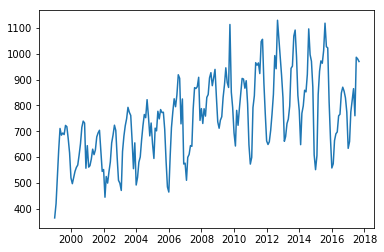

In [8]:
PRODUCTION = DATA[1]
DATA_DF = DATA[0]
plt.plot(PRODUCTION)
#print(DATA_DF.Sabah_Production_6, DATA_DF.Sabah_Production_12)

# 1. Additive VS Multiplicative

### Additive & Multiplicative

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

additive_decomposition  = seasonal_decompose(PRODUCTION, model='additive', freq=12)

multiplicative_decomposition = seasonal_decompose(PRODUCTION, model='multiplicative', freq=12)

#print("RESIDUALS", add_decomposition.resid)
#print("SEASONAL", add_decomposition.seasonal)
#print("TREND", add_decomposition.trend)
#print("OBSERVED", add_decomposition.observed)

### Additive Plots

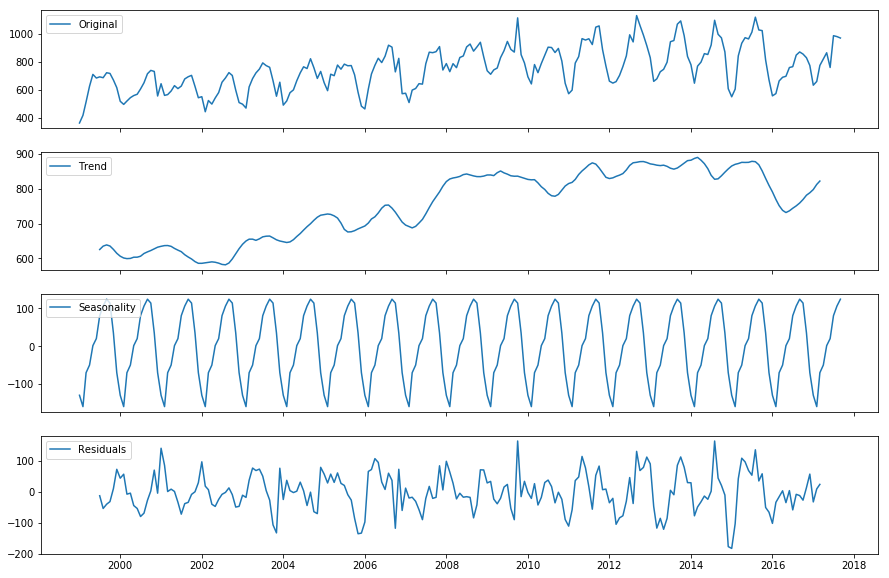

In [10]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(PRODUCTION, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(additive_decomposition.trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(additive_decomposition.seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(additive_decomposition.resid, label='Residuals')
axes[3].legend(loc='upper left');

### Multiplicative Plots

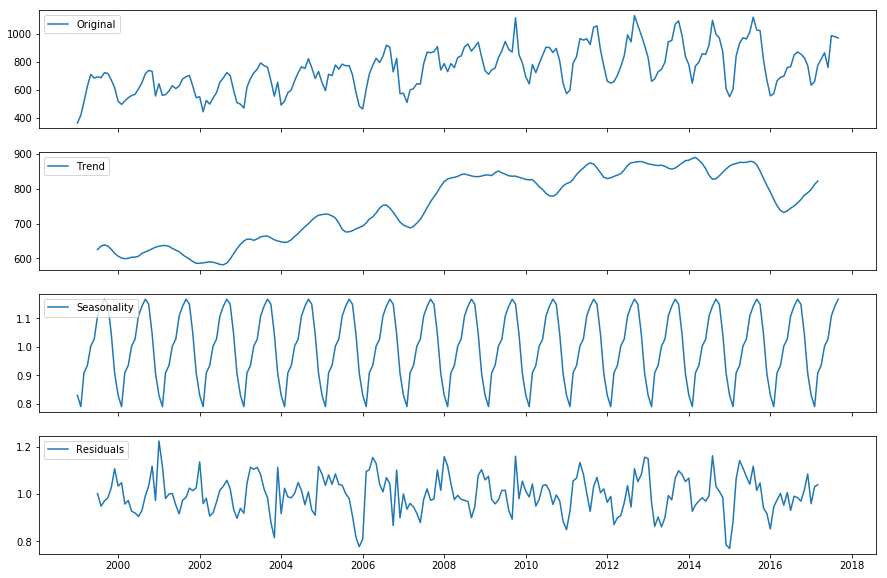

In [11]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(PRODUCTION, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(multiplicative_decomposition.trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(multiplicative_decomposition.seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(multiplicative_decomposition.resid, label='Residuals')
axes[3].legend(loc='upper left');

Based on the plots we can assume that our data has additive structure because we see not only trend but also an increasing variance, so let's check the summary statistics further to see if it's true.

# Stationarity Exploring

### Run-Sequence Plots

Text(0, 0.5, 'Production Value')

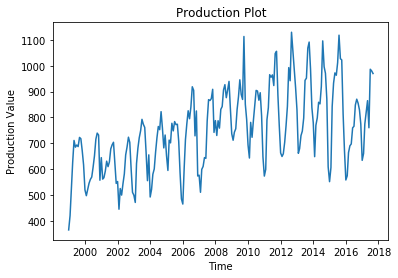

In [12]:
plt.plot(PRODUCTION)
plt.title('Production Plot')
plt.xlabel('Time')
plt.ylabel('Production Value')

Just with running the simplest sequence plot we see that there exists some trend and seasonality but there are not very clear here.
Let's explore how the mean and variances changes over time.

### Summary Statistics

In [13]:
#split the data into 7 chunks
chunks = np.array_split(PRODUCTION.values, indices_or_sections=7)


In [14]:
# compare means and variances
print("{} | {:7} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 26)
for i, chunk in enumerate(chunks):
    print("{:5} | {:.6} | {:.6}".format(i, np.mean(chunk), np.var(chunk)))

Chunk | Mean    | Variance
--------------------------
    0 | 613.435 | 8041.81
    1 | 615.517 | 9166.44
    2 | 721.078 | 11426.4
    3 | 798.222 | 11663.8
    4 | 814.645 | 18521.1
    5 | 872.707 | 21944.4
    6 | 822.625 | 21193.0


Actually, we see not so rapid increase in mean over chunks, which means that the production volume was increasing more or less gradually from year to year. Variance is constantly increasing in our data which can point to some heteroscedasticity which we would like to deal with.

### ADF test

In [15]:
#ADF test
from statsmodels.tsa.stattools import adfuller

def stationarity_test(ts):
    
    rolmean = ts.rolling(12).mean()
    rolstd = ts.rolling(12).std()

    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    # Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(ts, autolag='AIC')
    print(dftest)     
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)    
    #for (columnName, columnData) in ts.iteritems():
    #    dftest = adfuller(columnData)  
    #    print("DFTEST", dftest)
    #    dfoutput = pd.Series([dftest[0], dftest[1], columnName[-1], dftest[3]], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    #    for key,value in dftest[4].items():
    #        dfoutput['Critical Value (%s)'%key] = value
    #    print(dfoutput)   
    #    print("\n")

Results of Dickey-Fuller Test:
(-1.530376007768756, 0.5184348457498535, 15, 209, {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}, 2356.761168808326)
Test Statistic                  -1.530376
p-value                          0.518435
#Lags Used                      15.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64


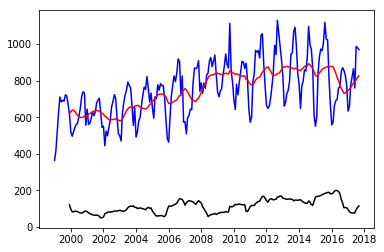

In [16]:

stationarity_test(PRODUCTION)


We immediately see a very big p-value which indicated that data is non-stationary because we can't reject the null hypothesis.

### Moving Average

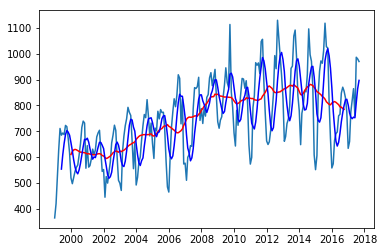

In [17]:
production_log = np.log(PRODUCTION)

moving_avg_center = PRODUCTION.rolling(24, center=True).mean()
moving_avg_right = PRODUCTION.rolling(6, center=False).mean()
plt.plot(PRODUCTION)
plt.plot(moving_avg_center, color='red')
plt.plot(moving_avg_right, color='blue')

We see that moving average with the window of length 24 is smoothing the data quite strong which is obviously more than smoothing with a window of 6. But again we observe some changes further in the data due to not constant variance.

#### Shocks

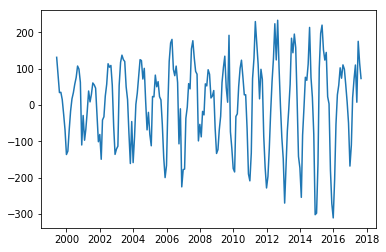

In [18]:
ma_diff = PRODUCTION - moving_avg_right
plt.plot(ma_diff)

Results of Dickey-Fuller Test:
(-6.3741624662171885, 2.305736402643704e-08, 13, 206, {'1%': -3.4624988216864776, '5%': -2.8756749365852587, '10%': -2.5743041549627677}, 2228.1528768000626)
Test Statistic                -6.374162e+00
p-value                        2.305736e-08
#Lags Used                     1.300000e+01
Number of Observations Used    2.060000e+02
Critical Value (1%)           -3.462499e+00
Critical Value (5%)           -2.875675e+00
Critical Value (10%)          -2.574304e+00
dtype: float64


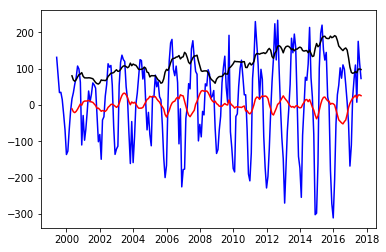

In [19]:
stationarity_test(ma_diff.dropna())

Based on p-value we can be sure that this approach makes our data more or less stationary.

### Exponential Smoothing

In [20]:
expweighted_avg = PRODUCTION.ewm(span=12).mean()

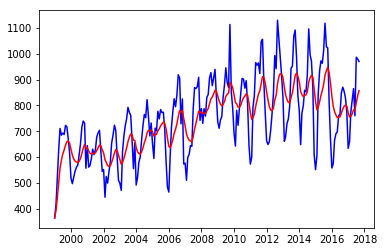

In [21]:
plt.plot(PRODUCTION, color="blue", label="Original")
plt.plot(expweighted_avg, color="red", label="EWMA")

#### Shocks

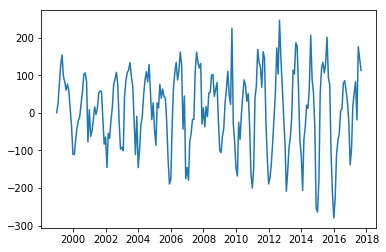

In [22]:
exp_diff = PRODUCTION - expweighted_avg
plt.plot(exp_diff)

Results of Dickey-Fuller Test:
(-5.640578358740035, 1.0387770456908053e-06, 13, 211, {'1%': -3.46172743446274, '5%': -2.8753374677799957, '10%': -2.574124089081557}, 2282.2270404068167)
Test Statistic                  -5.640578
p-value                          0.000001
#Lags Used                      13.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


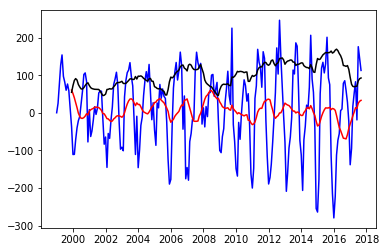

In [23]:
stationarity_test(exp_diff)

ADF test shows us much better result after the data is smoothed. P-value which is less than 0.05 so theoretically we can reject the null hypothesis and say that our data is stanionary but still p-value is not that small and doesn't imply that we can be actually confident. Also MA shows us better result based on p-value than EWMA. I think this is because Exponentially weighed MA puts more weight on last results which in our data are more volatile and has increased variance.

In [24]:
def decomposition_plots(ts, trend, seasonal, residual):
    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()

## Decomposition

### Additive

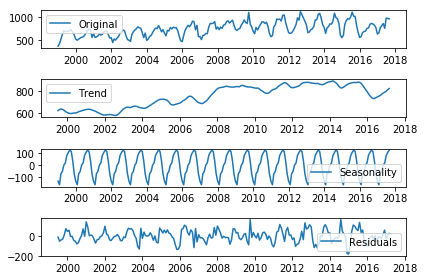

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

additive_decomposition  = seasonal_decompose(PRODUCTION, model='additive', freq=12)
additive_decomposition_res = additive_decomposition.resid
additive_decomposition_trend = additive_decomposition.trend
additive_decomposition_seasonal = additive_decomposition.seasonal
decomposition_plots(PRODUCTION, additive_decomposition_trend, additive_decomposition_seasonal, additive_decomposition_res)

#print("RESIDUALS", add_decomposition.resid)
#print("SEASONAL", add_decomposition.seasonal)
#print("TREND", add_decomposition.trend)
#print("OBSERVED", add_decomposition.observed)

### Multiplicative

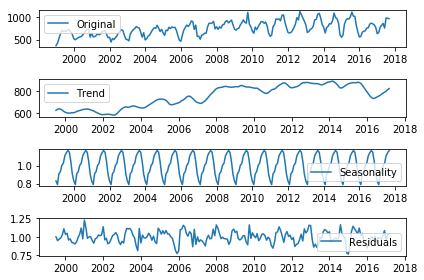

In [26]:
multiplicative_decomposition = seasonal_decompose(PRODUCTION, model='multiplicative', freq=12)
multiplicative_decomposition_res = multiplicative_decomposition.resid
multiplicative_decomposition_trend = multiplicative_decomposition.trend
multiplicative_decomposition_seasonal = multiplicative_decomposition.seasonal

decomposition_plots(PRODUCTION, multiplicative_decomposition_trend, multiplicative_decomposition_seasonal, multiplicative_decomposition_res)


#### Stationarity Test on additive

Results of Dickey-Fuller Test:
(-7.611191669118279, 2.2528342131131202e-11, 14, 198, {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}, 2097.228079567012)
Test Statistic                -7.611192e+00
p-value                        2.252834e-11
#Lags Used                     1.400000e+01
Number of Observations Used    1.980000e+02
Critical Value (1%)           -3.463815e+00
Critical Value (5%)           -2.876251e+00
Critical Value (10%)          -2.574611e+00
dtype: float64


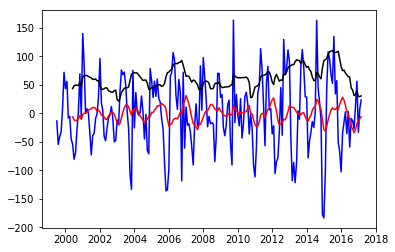

In [27]:
additive_decomposition_res.dropna(inplace=True)
stationarity_test(additive_decomposition_res)

#### Stationarity Test on multiplicative

Results of Dickey-Fuller Test:
(-7.465135160119532, 5.2286263171231255e-11, 12, 200, {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225}, -502.84902642295265)
Test Statistic                -7.465135e+00
p-value                        5.228626e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.000000e+02
Critical Value (1%)           -3.463476e+00
Critical Value (5%)           -2.876102e+00
Critical Value (10%)          -2.574532e+00
dtype: float64


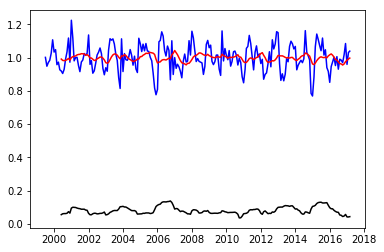

In [28]:
multiplicative_decomposition_res.dropna(inplace=True)
stationarity_test(multiplicative_decomposition_res)

Additive decompositin works better with our data based on summary statistics if ADF test. Multiplicative decomposition makes standard deviation really small, so our series doesn't look so volatile.

### Differencing

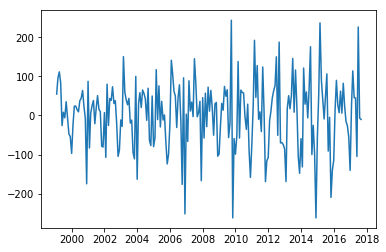

In [29]:

production_diff = PRODUCTION.diff(1)
plt.plot(production_diff)

Results of Dickey-Fuller Test:
(-6.079618077498949, 1.1002117264341212e-07, 14, 209, {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}, 2346.9246755730555)
Test Statistic                -6.079618e+00
p-value                        1.100212e-07
#Lags Used                     1.400000e+01
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


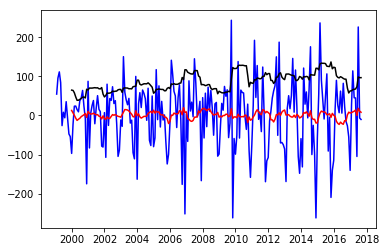

In [30]:
production_diff.dropna(inplace=True)
stationarity_test(production_diff)


### Log Trasformation

In [31]:
production_log = np.log(PRODUCTION)


#### Log Additive

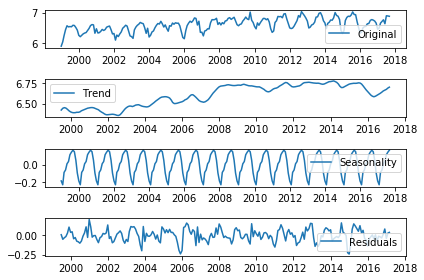

In [32]:
production_log_add = seasonal_decompose(production_log, model='additive', freq=12)
additive_decomposition_log_res = production_log_add.resid
additive_decomposition_log_trend = production_log_add.trend
additive_decomposition_log_seasonal = production_log_add.seasonal
decomposition_plots(production_log, additive_decomposition_log_trend, additive_decomposition_log_seasonal,additive_decomposition_log_res)
additive_decomposition_log_res = pd.Series(additive_decomposition_log_res, index=PRODUCTION.index).dropna()

#### Log Differencing

Results of Dickey-Fuller Test:
(-6.12242955978325, 8.789786442665288e-08, 14, 209, {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}, -398.12912262463055)
Test Statistic                -6.122430e+00
p-value                        8.789786e-08
#Lags Used                     1.400000e+01
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


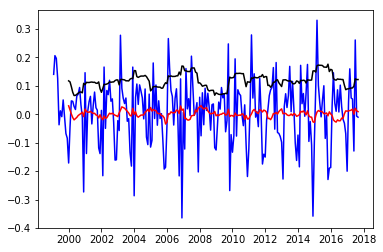

In [33]:
production_log_diff = production_log.diff(1)
production_log_diff.dropna(inplace=True)
stationarity_test(production_log_diff)

Everything brings time series to stationary series so far.

## Data Division

In [34]:
#for additive
test_PRODUCTION_add = additive_decomposition_res[(additive_decomposition_res.index.year.isin([2016, 2017]))]
val_PRODUCTION_add = additive_decomposition_res[(additive_decomposition_res.index.year.isin([2014, 2015]))]
train_PRODUCTION_add = additive_decomposition_res[~(additive_decomposition_res.index.year.isin([2014, 2015, 2016, 2017]))]

# for multiplicative
test_PRODUCTION_mul = multiplicative_decomposition_res[(multiplicative_decomposition_res.index.year.isin([2016, 2017]))]
val_PRODUCTION_mul = multiplicative_decomposition_res[(multiplicative_decomposition_res.index.year.isin([2014, 2015]))]
train_PRODUCTION_mul = multiplicative_decomposition_res[~(multiplicative_decomposition_res.index.year.isin([2014, 2015, 2016, 2017]))]

#for differencing
test_PRODUCTION_diff = production_diff[(production_diff.index.year.isin([2016, 2017]))]
val_PRODUCTION_diff = production_diff[(production_diff.index.year.isin([2014, 2015]))]
train_PRODUCTION_diff = production_diff[~(production_diff.index.year.isin([2014, 2015, 2016, 2017]))]

#for log additive
test_PRODUCTION_log_add = additive_decomposition_log_res[(additive_decomposition_log_res.index.year.isin([2016, 2017]))]
val_PRODUCTION_log_add = additive_decomposition_log_res[(additive_decomposition_log_res.index.year.isin([2014, 2015]))]
train_PRODUCTION_log_add = additive_decomposition_log_res[~(additive_decomposition_log_res.index.year.isin([2014, 2015, 2016, 2017]))]

#fot log differencing
test_PRODUCTION_log_diff = production_log_diff[(production_log_diff.index.year.isin([2016, 2017]))]
val_PRODUCTION_log_diff = production_log_diff[(production_log_diff.index.year.isin([2014, 2015]))]
train_PRODUCTION_log_diff = production_log_diff[~(production_log_diff.index.year.isin([2014, 2015, 2016, 2017]))]


## Model Valiadtion

### Moving Average

Predictions:  [0.21109956 0.21109956 0.21109956 0.21109956 0.21109956 0.21109956
 0.21109956 0.21109956 0.21109956 0.21109956 0.21109956 0.21109956
 0.21109956 0.21109956 0.21109956 0.21109956 0.21109956 0.21109956
 0.21109956 0.21109956 0.21109956 0.21109956 0.21109956 0.21109956]
MSE of predictions:  7336.4014334652775


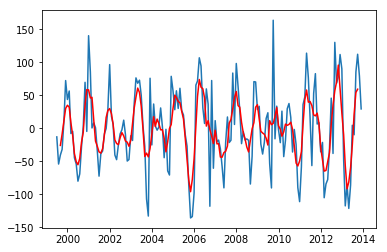

In [35]:
# find mean of series
trend_seasonal_avg = np.mean(train_PRODUCTION_add)

# create array of mean value equal to length of time array
simple_avg_preds = np.full(shape=len(val_PRODUCTION_add), fill_value=trend_seasonal_avg, dtype='float')
ts_moving_avg_center = train_PRODUCTION_add.rolling(5, center=True).mean()

# mse
from sklearn.metrics import mean_squared_error
simple_mse = mean_squared_error(val_PRODUCTION_add, simple_avg_preds)

# results
plt.plot(train_PRODUCTION_add)
plt.plot(ts_moving_avg_center, color='red')
print("Predictions: ", simple_avg_preds)
print("MSE of predictions: ", simple_mse)

### Simple Exponential Smoothing

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Predictions:  [0.21109956 0.21109956 0.21109956 0.21109956 0.21109956 0.21109956
 0.21109956 0.21109956 0.21109956 0.21109956 0.21109956 0.21109956
 0.21109956 0.21109956 0.21109956 0.21109956 0.21109956 0.21109956
 0.21109956 0.21109956 0.21109956 0.21109956 0.21109956 0.21109956]
MSE:  9368.443050195505


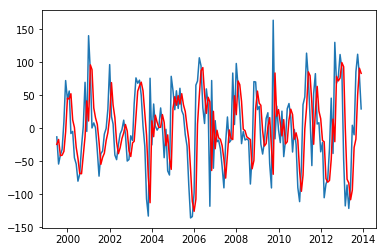

In [36]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
model = SimpleExpSmoothing(train_PRODUCTION_add)
fit1 = model.fit()
pred1 = fit1.forecast(24)
plt.plot(train_PRODUCTION_add)
plt.plot(fit1.fittedvalues, color='red')
pred1
simple_mse = mean_squared_error(val_PRODUCTION_add, pred1)

# results
print("Predictions: ", simple_avg_preds)
print("MSE: ", simple_mse)

In [37]:
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(train_PRODUCTION_add,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=12).fit(optimized=True)
triple_preds = triple.forecast(len(val_PRODUCTION_add))
triple_mse = mean_squared_error(val_PRODUCTION_add, triple_preds)
print("Predictions: ", triple_preds, "TRUE:", val_PRODUCTION_add)
print("MSE: ", triple_mse)

Predictions:  2014-01-01     7.774415
2014-02-01   -25.160092
2014-03-01   -50.398691
2014-04-01   -42.656043
2014-05-01   -37.193817
2014-06-01   -15.703245
2014-07-01    23.565888
2014-08-01   -16.274211
2014-09-01    52.488175
2014-10-01    67.500722
2014-11-01    43.546183
2014-12-01    28.382811
2015-01-01     8.457189
2015-02-01   -24.477318
2015-03-01   -49.715916
2015-04-01   -41.973269
2015-05-01   -36.511043
2015-06-01   -15.020470
2015-07-01    24.248662
2015-08-01   -15.591437
2015-09-01    53.170949
2015-10-01    68.183496
2015-11-01    44.228957
2015-12-01    29.065585
Freq: MS, dtype: float64 TRUE: 2014-01-01     28.677172
2014-02-01    -77.997819
2014-03-01    -49.516956
2014-04-01    -32.789443
2014-05-01    -14.224541
2014-06-01    -24.622152
2014-07-01      1.525257
2014-08-01    163.447202
2014-09-01     43.816887
2014-10-01     20.150428
2014-11-01    -10.956224
2014-12-01   -177.465768
2015-01-01   -183.304953
2015-02-01   -103.443278
2015-03-01     41.500794
2015

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


## Additive. ACF & PACF

In [38]:
from statsmodels.tsa.arima_model import ARIMA
#ACF and PACF plots:
# for additive
from statsmodels.tsa.stattools import acf, pacf
lag_acf_prod_add = acf(train_PRODUCTION_add, nlags=86)
lag_pacf_prod_add = pacf(train_PRODUCTION_add, nlags=86, method='ols')

[ 1.          0.45618154  0.23522767 -0.01804666 -0.27479167 -0.39083438
 -0.42665026 -0.34662775 -0.26884078 -0.07677429  0.00593782  0.15687527
  0.25129102  0.11112074  0.14144837  0.10243947  0.06991894  0.01121138
 -0.02615255 -0.02950502 -0.03191562 -0.04822681 -0.13490261  0.03701338
 -0.04585334 -0.07897857  0.04332777  0.05919715  0.076793    0.01677307
  0.01402691 -0.02496879 -0.04250471 -0.03950781 -0.09039608  0.11091511
 -0.10467812  0.01336841  0.04170901  0.02134398  0.04035448  0.00748149
  0.03966828  0.07178549  0.06203307 -0.05941282 -0.04876242  0.01282634
 -0.0722631  -0.00791962 -0.01305839 -0.04748122 -0.03432877 -0.00190868
  0.0018971  -0.02218309 -0.00657918 -0.04909726  0.08995247  0.05151746
  0.05159395  0.09792018  0.03486996  0.03542938 -0.03204006 -0.01244359
 -0.02554003 -0.03622139 -0.0384213  -0.12814892  0.0257134  -0.13868602
 -0.05760472 -0.01168657  0.07713351  0.12368279  0.12015094  0.12309307
  0.04760621  0.00551834 -0.04960157 -0.03602751 -0

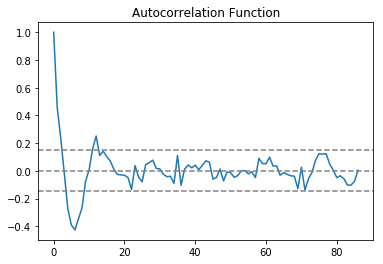

In [39]:
#Plot ACF
plt.plot(lag_acf_prod_add)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_PRODUCTION_add)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_PRODUCTION_add)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
print(lag_acf_prod_add)

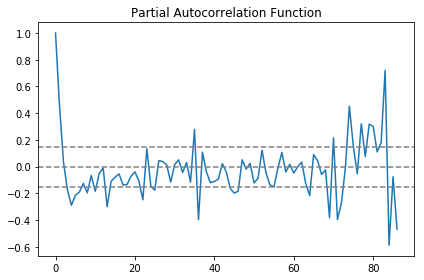

In [40]:
# Plot PACF
plt.plot(lag_pacf_prod_add)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_PRODUCTION_add)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_PRODUCTION_add)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## Additive. AR model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 627.9593')

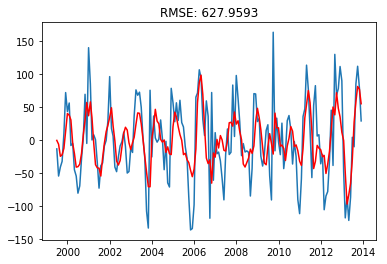

In [41]:
ar_model_prod_add = ARIMA(train_PRODUCTION_add, order=(7, 0, 0))
RESULT_ar_model_prod_add = ar_model_prod_add.fit(disp=-1)
plt.plot(train_PRODUCTION_add)
plt.plot(RESULT_ar_model_prod_add.fittedvalues, color='red')
RMSE_add_ar = np.sqrt(sum((RESULT_ar_model_prod_add.fittedvalues-train_PRODUCTION_add)**2))
plt.title('RMSE: %.4f'% RMSE_add_ar)



In [42]:
RESULT_ar_model_prod_add.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  resid   No. Observations:                  174
Model:                     ARMA(7, 0)   Log Likelihood                -919.483
Method:                       css-mle   S.D. of innovations             47.558
Date:                Tue, 27 Oct 2020   AIC                           1856.966
Time:                        16:15:06   BIC                           1885.398
Sample:                    07-01-1999   HQIC                          1868.500
                         - 12-01-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2907      2.844     -0.102      0.919      -5.866       5.284
ar.L1.resid     0.2715      0.075      3.615      0.000       0.124       0.419
ar.L2.resid     0.0781      0.077      1.014      0.310      -0.073       0.229
ar.L3.resid    -0.0430      0.077     -0.562      0.574      -0.193       0.107
ar.L4.resid    -0.1790      0.075     -2.377      0.017      -0.327      -0.031
ar.L5.resid    -0.1383      0.077     -1.807      0.071      -0.288       0.012
ar.L6.resid    -0.1518      0.077     -1.965      0.049      -0.303      -0.000
ar.L7.resid    -0.1218      0.076     -1.611      0.107      -0.270       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9263           -0.5447j            1.0746           -0.0846
AR.2            0.9263           +0.5447j            1.0746            0.0846
AR.3            0.2265           -1.4336j            1.4514           -0.2251
AR.4            0.2265           +1.4336j            1.4514            0.2251
AR.5           -0.9716           -1.0742j            1.4485           -0.3670
AR.6           -0.9716           +1.0742j            1.4485            0.3670
AR.7           -1.6084           -0.0000j            1.6084           -0.5000
-----------------------------------------------------------------------------
"""

### Additive. AR model. Validation

2014-01-01     4.907336
2014-02-01   -30.984233
2014-03-01   -50.976790
2014-04-01   -60.356729
2014-05-01   -49.962069
2014-06-01   -25.649520
2014-07-01     0.462121
2014-08-01    21.854576
2014-09-01    35.500106
2014-10-01    37.823118
2014-11-01    30.128865
2014-12-01    15.238126
2015-01-01    -1.831232
2015-02-01   -16.028407
2015-03-01   -24.197046
2015-04-01   -25.075327
2015-05-01   -19.342055
2015-06-01    -9.403770
2015-07-01     1.610207
2015-08-01    10.651263
2015-09-01    15.603414
2015-10-01    15.737206
2015-11-01    11.662634
2015-12-01     5.005693
Freq: MS, dtype: float64


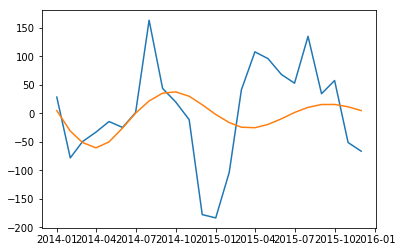

In [43]:
future_preds = RESULT_ar_model_prod_add.predict(start=val_PRODUCTION_add.index[0], end=val_PRODUCTION_add.index[-1])
print(future_preds)
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_add.index)
future_forecast_p = pd.concat([val_PRODUCTION_add,future_forecast],axis=1)
plt.plot(future_forecast_p)

In [44]:
from sklearn.metrics import mean_squared_error
RMSE_add_ar_val = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_add))
print(RMSE_add_ar_val)

85.46966926701975


## Additive. MA model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 587.4998')

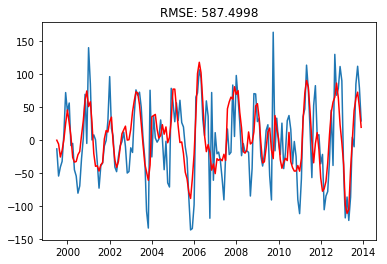

In [45]:
ma_model_prod_add = ARIMA(train_PRODUCTION_add, order=(0, 0, 10))
RESULT_ma_model_prod_add = ma_model_prod_add.fit(disp=-1)
plt.plot(train_PRODUCTION_add)
plt.plot(RESULT_ma_model_prod_add.fittedvalues, color='red')
RMSE_add_ma = np.sqrt(sum((RESULT_ma_model_prod_add.fittedvalues-train_PRODUCTION_add)**2))
plt.title('RMSE: %.4f'% RMSE_add_ma)


## Additive. ARMA model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 620.7254')

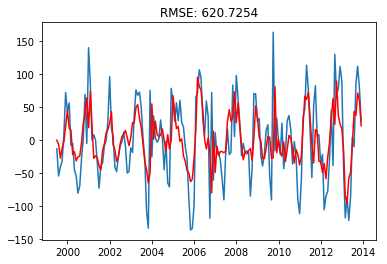

In [46]:
arma_model_prod_add = ARIMA(train_PRODUCTION_add, order=(2, 0, 1))
RESULT_arma_model_prod_add = arma_model_prod_add.fit(disp=-1)
plt.plot(train_PRODUCTION_add)
plt.plot(RESULT_arma_model_prod_add.fittedvalues, color='red')
RMSE_arma_add = np.sqrt(sum((RESULT_arma_model_prod_add.fittedvalues-train_PRODUCTION_add)**2))
plt.title('RMSE: %.4f'% RMSE_arma_add)

In [47]:
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
model_aic = LassoLarsIC(criterion='aic')

In [48]:
def optimize_ARIMA(order_list, exog):  
    results = []
    for order in (order_list):
        try: 
            model = ARIMA(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [49]:
from itertools import product
def make_orderlist(lst, typeofmodel):
    parameters_list = []
    if typeofmodel != "ARMA":
        for i in lst:
            parameters_list.append([i])
    else:
        parameters_list = list(lst)
    order_list = []
    for each in parameters_list:
        if typeofmodel == "AR":
            each = list(each)
            each.append(0)
            each.append(0)
            each = tuple(each)
            order_list.append(each)
        elif typeofmodel == "MA":
            each = list(each)
            each.insert(0, 0)
            each.insert(1, 0)
            each = tuple(each)
            order_list.append(each)
        else:
            each = list(each)
            each.insert(1, 0)
            each = tuple(each)
            order_list.append(each)
    return order_list

In [50]:
#df_optimized_AR = optimize_ARIMA(make_orderlist(range(0, 15, 1), "AR"), exog=train_PRODUCTION_add)
#print(df_optimized_AR)

## Additive. AR model. Optimized

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 579.1911')

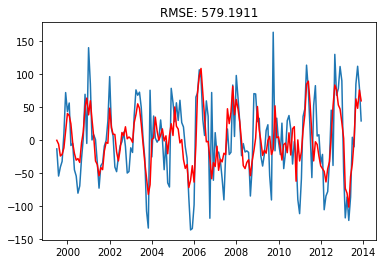

In [51]:
ar_model_prod_add = ARIMA(train_PRODUCTION_add, order=(13, 0, 0))
RESULT_ar_model_prod_add = ar_model_prod_add.fit(disp=-1)
plt.plot(train_PRODUCTION_add)
plt.plot(RESULT_ar_model_prod_add.fittedvalues, color='red')
RMSE_ar_add_opti = np.sqrt(sum((RESULT_ar_model_prod_add.fittedvalues-train_PRODUCTION_add)**2))
plt.title('RMSE: %.4f'% RMSE_ar_add_opti )

In [52]:
print("RMSE AR on additive, RMSE AR optimized on additive: \n", RMSE_add_ar, "      ", RMSE_ar_add_opti)

RMSE AR on additive, RMSE AR optimized on additive: 
 627.9593440501936        579.1910924899022


## Additive. AR model optimized. Validation

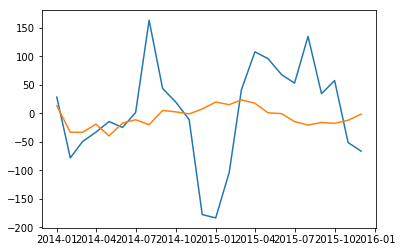

In [53]:
future_preds = RESULT_ar_model_prod_add.predict(start=val_PRODUCTION_add.index[0], end=val_PRODUCTION_add.index[-1])
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_add.index)
future_forecast_p = pd.concat([val_PRODUCTION_add,future_forecast],axis=1)
plt.plot(future_forecast_p)
from sklearn.metrics import mean_squared_error
RMSE_ar_add_val_opti = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_add))

In [54]:

print("Validation RMSE AR on additive, Validation RMSE AR optimized on additive: \n", RMSE_add_ar_val, "           ", RMSE_ar_add_val_opti)


Validation RMSE AR on additive, Validation RMSE AR optimized on additive: 
 85.46966926701975             89.83464206085517


In [55]:
# optimize MA
#df_optimized_MA = optimize_ARIMA(make_orderlist(range(0, 15, 1), "MA"), exog=train_PRODUCTION_add)
#print(df_optimized_MA)

## Additive. MA model. Optimized

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 558.7404')

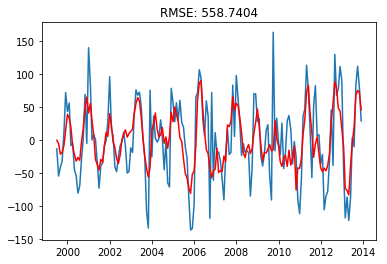

In [56]:
ma_model_prod_add = ARIMA(train_PRODUCTION_add, order=(0, 0, 12))
RESULT_ma_model_prod_add = ma_model_prod_add.fit(disp=-1)
plt.plot(train_PRODUCTION_add)
plt.plot(RESULT_ma_model_prod_add.fittedvalues, color='red')
RMSE_ma_add_opti = np.sqrt(sum((RESULT_ma_model_prod_add.fittedvalues-train_PRODUCTION_add)**2))
plt.title('RMSE: %.4f'% RMSE_ma_add_opti)


In [57]:
print("RMSE MA model       RMSE MA model Optimized:\n", RMSE_add_ma, "       ", RMSE_ma_add_opti)

RMSE MA model       RMSE MA model Optimized:
 587.4997925029635         558.7403648710252


### Additive. MA optimized. Validation

82.52595546991166


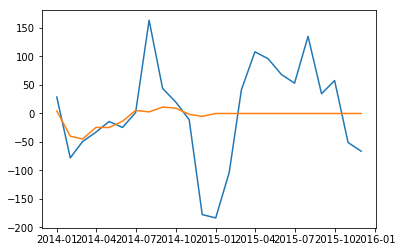

In [58]:
future_preds = RESULT_ma_model_prod_add.predict(start=val_PRODUCTION_add.index[0], end=val_PRODUCTION_add.index[-1])
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_add.index)
future_forecast_p = pd.concat([val_PRODUCTION_add,future_forecast],axis=1)
plt.plot(future_forecast_p)
from sklearn.metrics import mean_squared_error
RMSE_ma_add_opti_val = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_add))
print(RMSE_ma_add_opti_val)

## Additive. ARMA model. Optimized

In [59]:
# optimize ARMA
#df_optimized_ARMA = optimize_ARIMA(make_orderlist(product(range(0, 8, 1),range(0, 8, 1)), "ARMA"), exog=train_PRODUCTION_add)
#print(df_optimized_ARMA)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 551.4181')

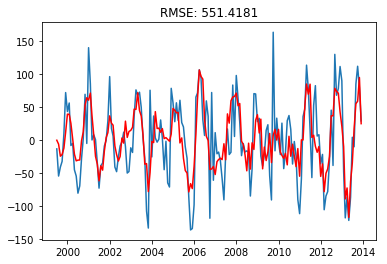

In [60]:
arma_model_prod_add = ARIMA(train_PRODUCTION_add, order=(6, 0, 3))
RESULT_arma_model_prod_add = arma_model_prod_add.fit(disp=-1)
plt.plot(train_PRODUCTION_add)
plt.plot(RESULT_arma_model_prod_add.fittedvalues, color='red')
RMSE_arma_add_opti = np.sqrt(sum((RESULT_arma_model_prod_add.fittedvalues-train_PRODUCTION_add)**2))
plt.title('RMSE: %.4f'% RMSE_arma_add_opti)

### Additive. ARMA optimized. Validation

93.38297661972031


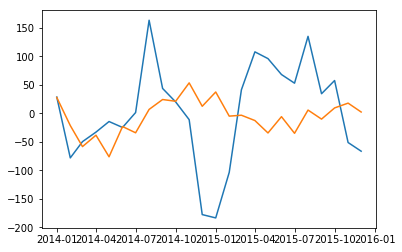

In [61]:
future_preds = RESULT_arma_model_prod_add.predict(start=val_PRODUCTION_add.index[0], end=val_PRODUCTION_add.index[-1])
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_add.index)
future_forecast_p = pd.concat([val_PRODUCTION_add,future_forecast],axis=1)
plt.plot(future_forecast_p)
from sklearn.metrics import mean_squared_error
RMSE_arma_add_opti_val = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_add))
print(RMSE_arma_add_opti_val)

## Additive. ARIMA model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 1041.1626')

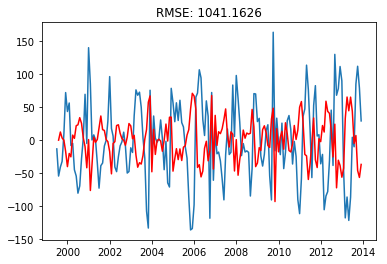

In [62]:
arima_model_prod_add = ARIMA(train_PRODUCTION_add, order=(2, 1, 1))
RESULT_arima_model_prod_add = arima_model_prod_add.fit(disp=-1)
plt.plot(train_PRODUCTION_add)
plt.plot(RESULT_arima_model_prod_add.fittedvalues, color='red')
arr = ((RESULT_arima_model_prod_add.fittedvalues-train_PRODUCTION_add)**2).dropna()
RMSE_arima_add = np.sqrt(sum(arr))
plt.title('RMSE: %.4f'% RMSE_arima_add)

### Additive Arima. Validation

85.47412243147289


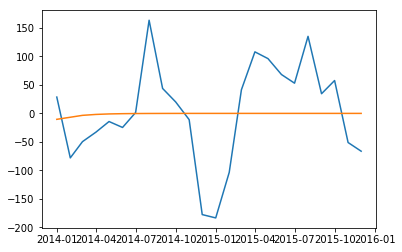

In [63]:
future_preds = RESULT_arima_model_prod_add.predict(start=val_PRODUCTION_add.index[0], end=val_PRODUCTION_add.index[-1])
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_add.index)
future_forecast_p = pd.concat([val_PRODUCTION_add,future_forecast],axis=1)
plt.plot(future_forecast_p)
from sklearn.metrics import mean_squared_error
RMSE_arima_add_val = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_add))
print(RMSE_arima_add_val)

## Comparison of models on Additive decomposition data

In [64]:
print("RMSE AR optimized       RMSE AR optimized validation")
print(RMSE_ar_add_opti, "      ", RMSE_ar_add_val_opti)
print("-----------------------------------------------------")
print("RMSE MA optimized       RMSE MA optimized validation")
print(RMSE_ma_add_opti, "      ", RMSE_ma_add_opti_val)
print("-----------------------------------------------------")
print("RMSE ARMA optimized       RMSE ARMA optimized validation")
print(RMSE_arma_add_opti, "      ", RMSE_arma_add_opti_val)
print("-----------------------------------------------------")
print("RMSE ARIMA       RMSE ARMA validation")
print(RMSE_arima_add, "      ", RMSE_arima_add_val)

RMSE AR optimized       RMSE AR optimized validation
579.1910924899022        89.83464206085517
-----------------------------------------------------
RMSE MA optimized       RMSE MA optimized validation
558.7403648710252        82.52595546991166
-----------------------------------------------------
RMSE ARMA optimized       RMSE ARMA optimized validation
551.4181125979104        93.38297661972031
-----------------------------------------------------
RMSE ARIMA       RMSE ARMA validation
1041.1626152676147        85.47412243147289


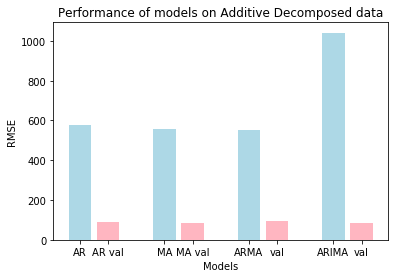

In [65]:
x_units = [1, 2, 4, 5, 7, 8, 10, 11]

y_units = [RMSE_ar_add_opti, RMSE_ar_add_val_opti, RMSE_ma_add_opti, RMSE_ma_add_opti_val, RMSE_arma_add_opti, RMSE_arma_add_opti_val, 
          RMSE_arima_add,RMSE_arima_add_val]

tick_label = ['AR', 'AR val', 'MA', 'MA val', 'ARMA', 
             'val', 'ARIMA', 'val']

plt.bar(x_units, y_units, tick_label=tick_label, color=['lightblue', 'lightpink'])

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Performance of models on Additive Decomposed data')

plt.show()

With additive decomposed data the best performing models are MA and ARMA, which we will consider during test

## Differenced. ACF & PACF

In [66]:
from statsmodels.tsa.arima_model import ARIMA
#ACF and PACF plots:
# for differenced
from statsmodels.tsa.stattools import acf, pacf
lag_acf_prod_diff = acf(train_PRODUCTION_diff, nlags=40)
lag_pacf_prod_diff = pacf(train_PRODUCTION_diff, nlags=40, method='ols')

[ 1.          0.06206998  0.17037703 -0.06957084 -0.17759447 -0.24537785
 -0.22466824 -0.2588749  -0.23524184 -0.08009924  0.06882089  0.19274824
  0.48950492  0.10915061  0.18729828 -0.06107641 -0.06056031 -0.18221845
 -0.16003909 -0.20967992 -0.1390124  -0.06522161 -0.04736499  0.29985226
  0.32004245  0.08884077  0.18344225 -0.07318084 -0.0334485  -0.19775696
 -0.14605595 -0.2114567  -0.1377449  -0.06455937 -0.04849128  0.37784354
  0.13004492  0.19324995  0.16018074 -0.0716675  -0.04337949]


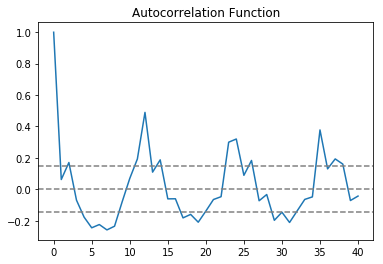

In [67]:
#Plot ACF
plt.plot(lag_acf_prod_diff)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_PRODUCTION_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_PRODUCTION_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
print(lag_acf_prod_diff)

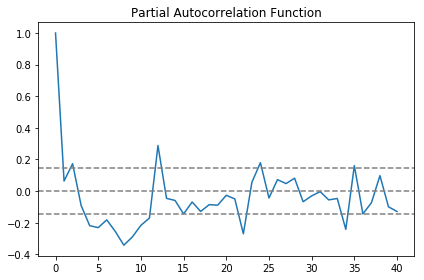

In [68]:
# Plot PACF
plt.plot(lag_pacf_prod_diff)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_PRODUCTION_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_PRODUCTION_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## Differenced. AR model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 853.7876')

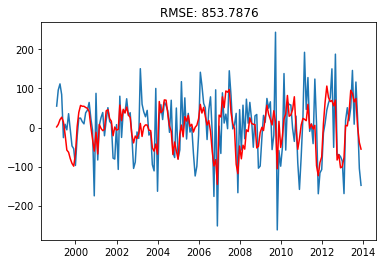

In [69]:
ar_model_prod_diff = ARIMA(train_PRODUCTION_diff, order=(10, 0, 0))
RESULT_ar_model_prod_diff = ar_model_prod_diff.fit(disp=-1)
plt.plot(train_PRODUCTION_diff)
plt.plot(RESULT_ar_model_prod_diff.fittedvalues, color='red')
RMSE_ar_diff = np.sqrt(sum((RESULT_ar_model_prod_diff.fittedvalues-train_PRODUCTION_diff)**2))
plt.title('RMSE: %.4f'% RMSE_ar_diff)

### Differenced AR model. Validation

106.87289519402378


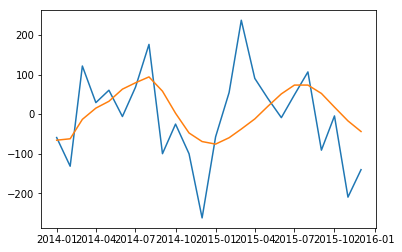

In [70]:
future_preds = RESULT_ar_model_prod_diff.predict(start=val_PRODUCTION_diff.index[0], end=val_PRODUCTION_diff.index[-1])
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_diff.index)
future_forecast_p = pd.concat([val_PRODUCTION_diff,future_forecast],axis=1)
plt.plot(future_forecast_p)
from sklearn.metrics import mean_squared_error
RMSE_ar_diff_val = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_diff))
print(RMSE_ar_diff_val)

In [71]:
#df_optimized_AR_diff = optimize_ARIMA(make_orderlist(range(0, 15, 1), "AR"), exog=train_PRODUCTION_diff)
#print(df_optimized_AR_diff)

### Differenced AR model. Optimization

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 1203.61666')

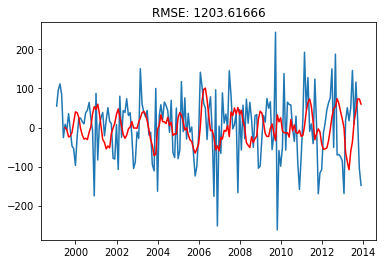

In [72]:
ar_model_prod_diff = ARIMA(train_PRODUCTION_add, order=(12, 0, 0))
RESULT_ar_model_prod_diff = ar_model_prod_diff.fit(disp=-1)
plt.plot(train_PRODUCTION_diff)
plt.plot(RESULT_ar_model_prod_diff.fittedvalues, color='red')
arr = ((RESULT_ar_model_prod_diff.fittedvalues-train_PRODUCTION_diff)**2).dropna()
RMSE_ar_diff_opti = np.sqrt(sum(arr))
plt.title('RMSE: %.5f'% RMSE_ar_diff_opti)

### Differenced AR model optimized. Validation

132.8228339153335


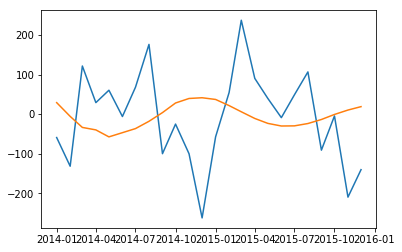

In [73]:
future_preds = RESULT_ar_model_prod_diff.predict(start=val_PRODUCTION_diff.index[0], end=val_PRODUCTION_diff.index[-1])
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_diff.index)
future_forecast_p = pd.concat([val_PRODUCTION_diff,future_forecast],axis=1)
plt.plot(future_forecast_p)
from sklearn.metrics import mean_squared_error
RMSE_ar_diff_opti_val = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_diff))
print(RMSE_ar_diff_opti_val)

### Differenced. MA model. Optimization

In [74]:
#df_optimized_MA_diff = optimize_ARIMA(make_orderlist(range(0, 15, 1), "MA"), exog=train_PRODUCTION_diff)
#print(df_optimized_MA_diff)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 840.97992')

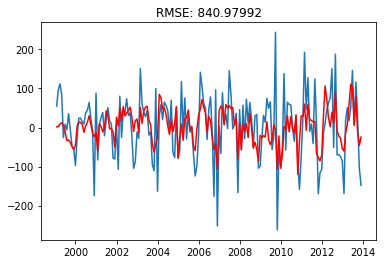

In [75]:
ma_model_prod_diff = ARIMA(train_PRODUCTION_diff, order=(0, 0, 12))
RESULT_ma_model_prod_diff = ma_model_prod_diff.fit(disp=-1)
plt.plot(train_PRODUCTION_diff)
plt.plot(RESULT_ma_model_prod_diff.fittedvalues, color='red')
RMSE_ma_diff_opti = np.sqrt(sum((RESULT_ma_model_prod_diff.fittedvalues-train_PRODUCTION_diff)**2))
plt.title('RMSE: %.5f'% RMSE_ma_diff_opti)

### Differenced. MA model Optimized. Validation

105.35205594803939


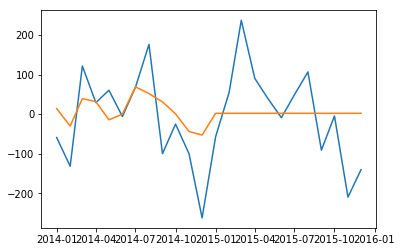

In [76]:
future_preds = RESULT_ma_model_prod_diff.predict(start=val_PRODUCTION_diff.index[0], end=val_PRODUCTION_diff.index[-1])
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_diff.index)
future_forecast_p = pd.concat([val_PRODUCTION_diff,future_forecast],axis=1)
plt.plot(future_forecast_p)
from sklearn.metrics import mean_squared_error
RMSE_ma_diff_opti_val = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_diff))
print(RMSE_ma_diff_opti_val)

### Differenced. ARMA model Optimization

In [77]:
# optimize ARMA
#df_optimized_ARMA = optimize_ARIMA(make_orderlist(product(range(0, 8, 1),range(0, 8, 1)), "ARMA"), exog=train_PRODUCTION_diff)
#print(df_optimized_ARMA)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Text(0.5, 1.0, 'RMSE: 783.97142')

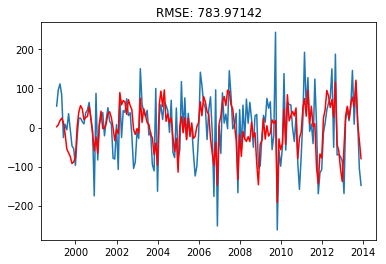

In [78]:
arma_model_prod_diff = ARIMA(train_PRODUCTION_diff, order=(6, 0, 7))
RESULT_arma_model_prod_diff = arma_model_prod_diff.fit(disp=-1)
plt.plot(train_PRODUCTION_diff)
plt.plot(RESULT_arma_model_prod_diff.fittedvalues, color='red')
RMSE_arma_diff_opti = np.sqrt(sum((RESULT_arma_model_prod_diff.fittedvalues-train_PRODUCTION_diff)**2))
plt.title('RMSE: %.5f'% RMSE_arma_diff_opti)

### Differenced. ARMA model Optimized. Validation

93.55923292969536


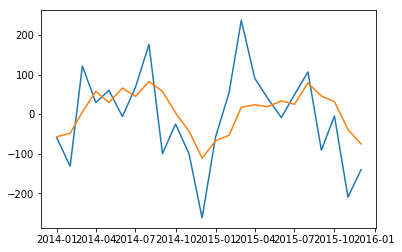

In [79]:
future_preds = RESULT_arma_model_prod_diff.predict(start=val_PRODUCTION_diff.index[0], end=val_PRODUCTION_diff.index[-1])
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_diff.index)
future_forecast_p = pd.concat([val_PRODUCTION_diff,future_forecast],axis=1)
plt.plot(future_forecast_p)
from sklearn.metrics import mean_squared_error
RMSE_arma_diff_opti_val = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_diff))
print(RMSE_arma_diff_opti_val)

### Differenced. ARIMA model. 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 1346.5269')

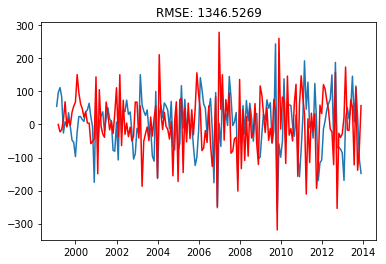

In [80]:
arima_model_prod_diff = ARIMA(train_PRODUCTION_diff, order=(14, 1, 1))
RESULT_arima_model_prod_diff = arima_model_prod_diff.fit(disp=-1)
plt.plot(train_PRODUCTION_diff)
plt.plot(RESULT_arima_model_prod_diff.fittedvalues, color='red')
arr = ((RESULT_arima_model_prod_diff.fittedvalues-train_PRODUCTION_diff)**2).dropna()
RMSE_arima_diff = np.sqrt(sum(arr))
plt.title('RMSE: %.4f'% RMSE_arima_diff)

### Differenced. ARIMA model. Validation

107.9953750234846


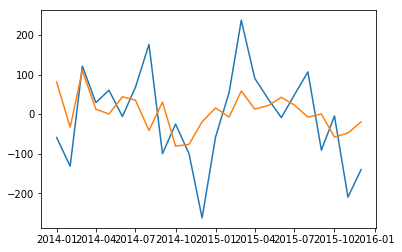

In [81]:
future_preds = RESULT_arima_model_prod_diff.predict(start=val_PRODUCTION_diff.index[0], end=val_PRODUCTION_diff.index[-1])
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_diff.index)
future_forecast_p = pd.concat([val_PRODUCTION_diff,future_forecast],axis=1)
plt.plot(future_forecast_p)
from sklearn.metrics import mean_squared_error
RMSE_arima_diff_val = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_diff))
print(RMSE_arima_diff_val)

## Comparison of models' RMSE on Differenced Data

In [82]:
print("RMSE AR optimized       RMSE AR optimized validation")
print(RMSE_ar_diff_opti, "      ", RMSE_ar_diff_opti_val)
print("-----------------------------------------------------")
print("RMSE MA optimized       RMSE MA optimized validation")
print(RMSE_ma_diff_opti, "      ", RMSE_ma_diff_opti_val)
print("-----------------------------------------------------")
print("RMSE ARMA optimized       RMSE ARMA optimized validation")
print(RMSE_arma_diff_opti, "      ", RMSE_arma_diff_opti_val)
print("-----------------------------------------------------")
print("RMSE ARIMA             RMSE ARMA validation")
print(RMSE_arima_diff, "      ", RMSE_arima_diff_val)

RMSE AR optimized       RMSE AR optimized validation
1203.6166642737767        132.8228339153335
-----------------------------------------------------
RMSE MA optimized       RMSE MA optimized validation
840.9799249679776        105.35205594803939
-----------------------------------------------------
RMSE ARMA optimized       RMSE ARMA optimized validation
783.9714196169411        93.55923292969536
-----------------------------------------------------
RMSE ARIMA             RMSE ARMA validation
1346.5269366125588        107.9953750234846


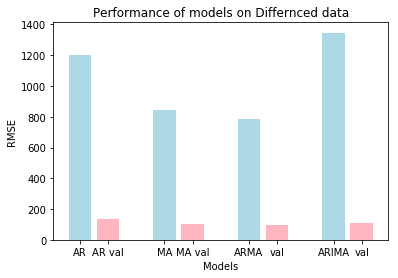

In [83]:
x_units = [1, 2, 4, 5, 7, 8, 10, 11]

y_units = [RMSE_ar_diff_opti, RMSE_ar_diff_opti_val, RMSE_ma_diff_opti, RMSE_ma_diff_opti_val, RMSE_arma_diff_opti, RMSE_arma_diff_opti_val, 
          RMSE_arima_diff,RMSE_arima_diff_val]

tick_label = ['AR', 'AR val', 'MA', 'MA val', 'ARMA', 
             'val', 'ARIMA', 'val']

plt.bar(x_units, y_units, tick_label=tick_label, color=['lightblue', 'lightpink'])

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Performance of models on Differnced data')

plt.show()

After running AR, MA, ARMA and ARIMA models on diffenced data we observe MA and ARMA be the bets performing according to RMSE of model and its validation.

## Log Additive. ACF & PACF

In [84]:
from statsmodels.tsa.arima_model import ARIMA
#ACF and PACF plots:
# for log additive
from statsmodels.tsa.stattools import acf, pacf
lag_acf_prod_log_add = acf(train_PRODUCTION_log_add, nlags=40)
lag_pacf_prod_log_add = pacf(train_PRODUCTION_log_add, nlags=40, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

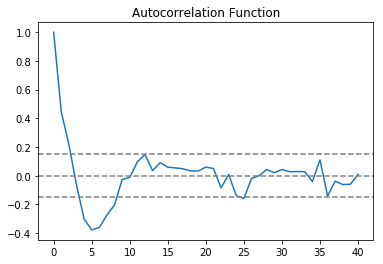

In [85]:
#Plot ACF
plt.plot(lag_acf_prod_log_add)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_PRODUCTION_log_add)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_PRODUCTION_log_add)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

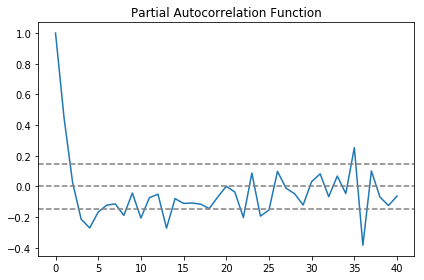

In [86]:
# Plot PACF
plt.plot(lag_pacf_prod_log_add)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_PRODUCTION_log_add)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_PRODUCTION_log_add)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### Log Additive. AR model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 0.8446')

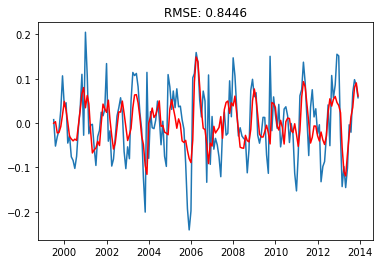

In [87]:
ar_model_prod_log_add = ARIMA(train_PRODUCTION_log_add, order=(8, 0, 0))
RESULT_ar_model_prod_log_add = ar_model_prod_log_add.fit(disp=-1)
plt.plot(train_PRODUCTION_log_add)
plt.plot(RESULT_ar_model_prod_log_add.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((RESULT_ar_model_prod_log_add.fittedvalues-train_PRODUCTION_log_add)**2)))

### Log Additive. AR model. Validation

1.6519445087065325e+47


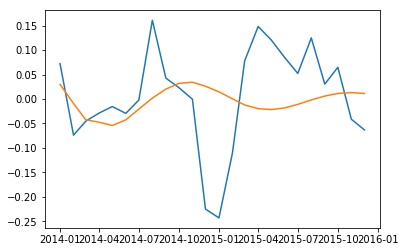

In [88]:
future_preds_log_add = RESULT_ar_model_prod_log_add.predict(start=val_PRODUCTION_log_add.index[0], end=val_PRODUCTION_log_add.index[-1])
future_preds_log_add = pd.DataFrame(future_preds_log_add,index = val_PRODUCTION_log_add.index)
future_preds_log_add_p = pd.concat([val_PRODUCTION_log_add,future_preds_log_add],axis=1)
plt.plot(future_preds_log_add_p)

from sklearn.metrics import mean_squared_error
RMSE_ar_log_add_val = np.sqrt(mean_squared_error(np.exp(future_forecast), np.exp(val_PRODUCTION_log_add)))
print(RMSE_ar_log_add_val)

### Log Additive. AR model. Optimization

In [89]:
#df_optimized_AR_log_add = optimize_ARIMA(make_orderlist(range(0, 15, 1), "AR"), exog=train_PRODUCTION_log_add)
#print(df_optimized_AR_log_add)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 0.7950')

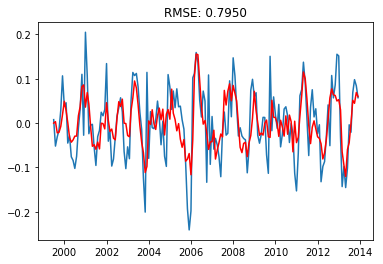

In [90]:
ar_model_prod_log_add = ARIMA(train_PRODUCTION_log_add, order=(13, 0, 0))
RESULT_ar_model_prod_log_add = ar_model_prod_log_add.fit(disp=-1)
plt.plot(train_PRODUCTION_log_add)
plt.plot(RESULT_ar_model_prod_log_add.fittedvalues, color='red')
RMSE_ar_log_add_opti = np.sqrt(sum((RESULT_ar_model_prod_log_add.fittedvalues-train_PRODUCTION_log_add)**2))
plt.title('RMSE: %.4f'% RMSE_ar_log_add_opti)

### Log Additive. AR model Optimized. Validation

0.1012292977417416


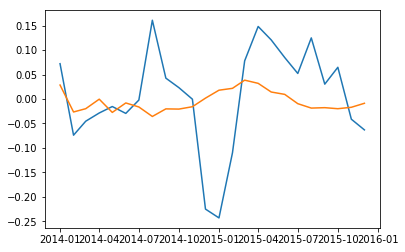

In [91]:
future_preds_log_add = RESULT_ar_model_prod_log_add.predict(start=val_PRODUCTION_log_add.index[0], end=val_PRODUCTION_log_add.index[-1])
future_preds_log_add = pd.DataFrame(future_preds_log_add,index = val_PRODUCTION_log_add.index)
future_preds_log_add_p = pd.concat([val_PRODUCTION_log_add,future_preds_log_add],axis=1)
plt.plot(future_preds_log_add_p)

from sklearn.metrics import mean_squared_error
RMSE_ar_log_add_val_opti = np.sqrt(mean_squared_error(np.exp(future_preds_log_add), np.exp(val_PRODUCTION_log_add)))
print(RMSE_ar_log_add_val_opti)


### Log Additive. MA model Optimization

In [92]:
#df_optimized_MA_log_add = optimize_ARIMA(make_orderlist(range(0, 15, 1), "MA"), exog=train_PRODUCTION_log_add)
#print(df_optimized_MA_log_add)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Text(0.5, 1.0, 'RMSE: 0.7659')

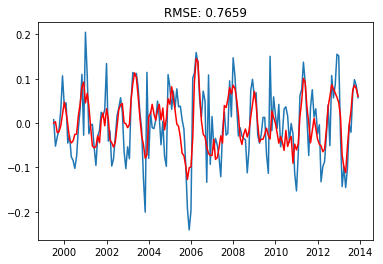

In [93]:
ma_model_prod_log_add = ARIMA(train_PRODUCTION_log_add, order=(0, 0, 12))
RESULT_ma_model_prod_log_add = ma_model_prod_log_add.fit(disp=-1)
plt.plot(train_PRODUCTION_log_add)
plt.plot(RESULT_ma_model_prod_log_add.fittedvalues, color='red')
RMSE_ma_log_add_opti = np.sqrt(sum((RESULT_ma_model_prod_log_add.fittedvalues-train_PRODUCTION_log_add)**2))
plt.title('RMSE: %.4f'% RMSE_ma_log_add_opti)

### Log Additive. MA model Optimized. Validation

0.09718084958912455


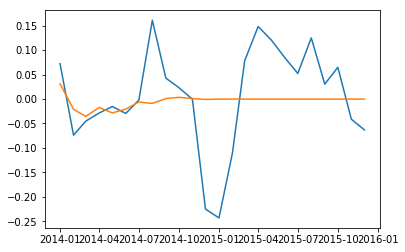

In [94]:
future_preds_log_add = RESULT_ma_model_prod_log_add.predict(start=val_PRODUCTION_log_add.index[0], end=val_PRODUCTION_log_add.index[-1])
future_preds_log_add = pd.DataFrame(future_preds_log_add,index = val_PRODUCTION_log_add.index)
future_preds_log_add_p = pd.concat([val_PRODUCTION_log_add,future_preds_log_add],axis=1)
plt.plot(future_preds_log_add_p)

from sklearn.metrics import mean_squared_error
RMSE_ma_log_add_val_opti = np.sqrt(mean_squared_error(np.exp(future_preds_log_add), np.exp(val_PRODUCTION_log_add)))
print(RMSE_ma_log_add_val_opti)

### Log Additive. ARMA model. Optimization

In [95]:
#df_optimized_ARMA_log_add = optimize_ARIMA(make_orderlist(product(range(0, 8, 1),range(0, 8, 1)), "ARMA"), exog=train_PRODUCTION_log_add)
#print(df_optimized_ARMA_log_add)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Text(0.5, 1.0, 'RMSE: 0.7685')

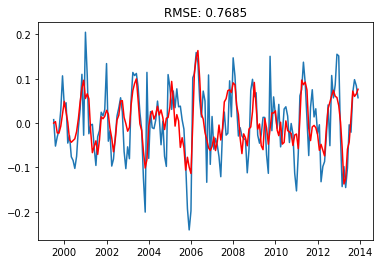

In [96]:
arma_model_prod_log_add = ARIMA(train_PRODUCTION_log_add, order=(5, 0, 3))
RESULT_arma_model_prod_log_add = arma_model_prod_log_add.fit(disp=-1)
plt.plot(train_PRODUCTION_log_add)
plt.plot(RESULT_arma_model_prod_log_add.fittedvalues, color='red')
RMSE_arma_log_add_opti = np.sqrt(sum((RESULT_arma_model_prod_log_add.fittedvalues-train_PRODUCTION_log_add)**2))
plt.title('RMSE: %.4f'% RMSE_arma_log_add_opti)

### Log Additive. ARMA model. Validation

0.10188553034906919


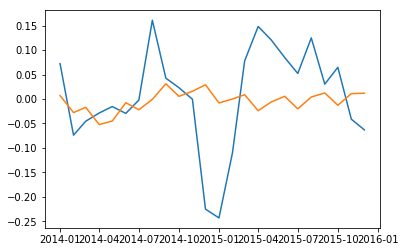

In [97]:

future_preds_log_add = RESULT_arma_model_prod_log_add.predict(start=val_PRODUCTION_log_add.index[0], end=val_PRODUCTION_log_add.index[-1])
future_preds_log_add = pd.DataFrame(future_preds_log_add,index = val_PRODUCTION_log_add.index)
future_preds_log_add_p = pd.concat([val_PRODUCTION_log_add,future_preds_log_add],axis=1)
plt.plot(future_preds_log_add_p)

from sklearn.metrics import mean_squared_error
RMSE_arma_log_add_val_opti = np.sqrt(mean_squared_error(np.exp(future_preds_log_add), np.exp(val_PRODUCTION_log_add)))
print(RMSE_arma_log_add_val_opti)

### Log Additive. ARIMA model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Text(0.5, 1.0, 'RMSE: 1.2900')

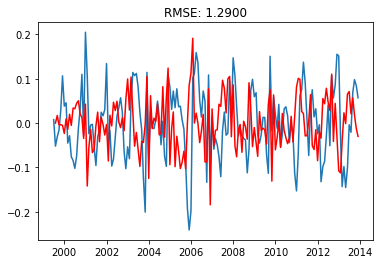

In [98]:
arima_model_log_add = ARIMA(train_PRODUCTION_log_add, order=(8, 1, 4))
RESULT_arima_model_log_add = arima_model_log_add.fit(disp=-1)
plt.plot(train_PRODUCTION_log_add)
plt.plot(RESULT_arima_model_log_add.fittedvalues, color='red')
arr = ((RESULT_arima_model_log_add.fittedvalues-train_PRODUCTION_log_add)**2).dropna()
RMSE_arima_log_add = np.sqrt(sum(arr))
plt.title('RMSE: %.4f'% RMSE_arima_log_add)

### Log Additive. ARIME model. Validation

0.10384843756521885


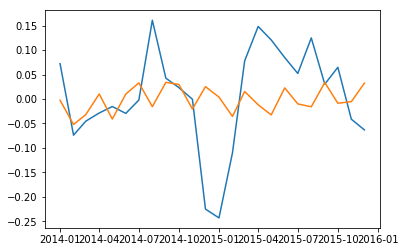

In [99]:

future_preds_log_add = RESULT_arima_model_log_add.predict(start=val_PRODUCTION_log_add.index[0], end=val_PRODUCTION_log_add.index[-1])
future_preds_log_add = pd.DataFrame(future_preds_log_add,index = val_PRODUCTION_log_add.index)
future_preds_log_add_p = pd.concat([val_PRODUCTION_log_add,future_preds_log_add],axis=1)
plt.plot(future_preds_log_add_p)

from sklearn.metrics import mean_squared_error
RMSE_arima_log_add_val_opti = np.sqrt(mean_squared_error(np.exp(future_preds_log_add), np.exp(val_PRODUCTION_log_add)))
print(RMSE_arima_log_add_val_opti)

## Comparison of models' RMSE on Log additive data

In [100]:
print("RMSE AR optimized       RMSE AR optimized validation")
print(RMSE_ar_log_add_opti, "      ", RMSE_ar_log_add_val_opti)
print("-----------------------------------------------------")
print("RMSE MA optimized       RMSE MA optimized validation")
print(RMSE_ma_log_add_opti, "      ", RMSE_ma_log_add_val_opti)
print("-----------------------------------------------------")
print("RMSE ARMA optimized       RMSE ARMA optimized validation")
print(RMSE_arma_log_add_opti, "      ", RMSE_arma_log_add_val_opti)
print("-----------------------------------------------------")
print("RMSE ARIMA       RMSE ARMA validation")
print(RMSE_arima_log_add, "      ", RMSE_arima_log_add_val_opti)

RMSE AR optimized       RMSE AR optimized validation
0.7949642191413249        0.1012292977417416
-----------------------------------------------------
RMSE MA optimized       RMSE MA optimized validation
0.765888578105504        0.09718084958912455
-----------------------------------------------------
RMSE ARMA optimized       RMSE ARMA optimized validation
0.7685310377826517        0.10188553034906919
-----------------------------------------------------
RMSE ARIMA       RMSE ARMA validation
1.2899591435388353        0.10384843756521885


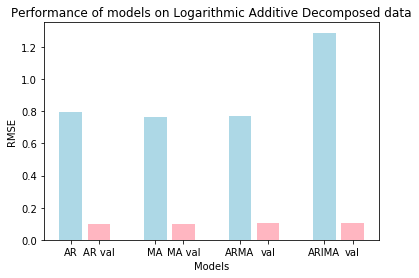

In [101]:
x_units = [1, 2, 4, 5, 7, 8, 10, 11]

y_units = [RMSE_ar_log_add_opti, RMSE_ar_log_add_val_opti, RMSE_ma_log_add_opti, RMSE_ma_log_add_val_opti, RMSE_arma_log_add_opti, RMSE_arma_log_add_val_opti, 
          RMSE_arima_log_add, RMSE_arima_log_add_val_opti]

tick_label = ['AR', 'AR val', 'MA', 'MA val', 'ARMA', 
             'val', 'ARIMA', 'val']

plt.bar(x_units, y_units, tick_label=tick_label, color=['lightblue', 'lightpink'])

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Performance of models on Logarithmic Additive Decomposed data')

plt.show()

On logarithmic additive decomposed data the best performing models are MA ans ARMA.

### Log Differenced. AR model. Optimization

In [102]:
#df_optimized_AR_log_diff = optimize_ARIMA(make_orderlist(range(0, 15, 1), "AR"), exog=train_PRODUCTION_log_diff)
#print(df_optimized_AR_log_diff)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 1.16648')

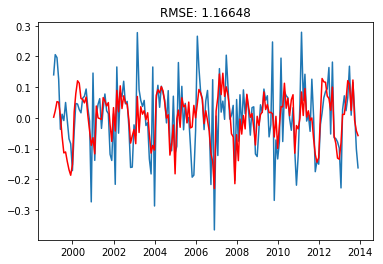

In [103]:
ar_model_prod_log_diff = ARIMA(train_PRODUCTION_log_diff, order=(12, 0, 0))
RESULT_ar_model_prod_log_diff = ar_model_prod_log_diff.fit(disp=-1)
plt.plot(train_PRODUCTION_log_diff)
plt.plot(RESULT_ar_model_prod_log_diff.fittedvalues, color='red')
arr = ((RESULT_ar_model_prod_log_diff.fittedvalues-train_PRODUCTION_log_diff)**2).dropna()
RMSE_ar_log_diff_opti = np.sqrt(sum(arr))
plt.title('RMSE: %.5f'% RMSE_ar_log_diff_opti)

### Log Differenced. AR model Optimized. Validation

0.1327024811218064


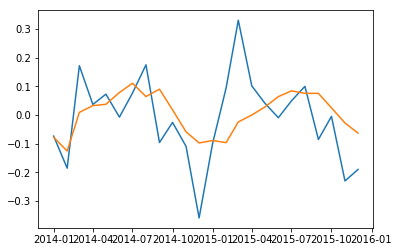

In [104]:
future_preds = RESULT_ar_model_prod_log_diff.predict(start=val_PRODUCTION_log_diff.index[0], end=val_PRODUCTION_log_diff.index[-1])
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_log_diff.index)
future_forecast_p = pd.concat([val_PRODUCTION_log_diff,future_forecast],axis=1)
plt.plot(future_forecast_p)
from sklearn.metrics import mean_squared_error
RMSE_ar_log_diff_opti_val = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_log_diff))
print(RMSE_ar_log_diff_opti_val)

### Log Differenced. MA model Optimization

In [105]:
#df_optimized_MA_log_diff = optimize_ARIMA(make_orderlist(range(0, 15, 1), "MA"), exog=train_PRODUCTION_log_diff)
#print(df_optimized_MA_log_diff)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Text(0.5, 1.0, 'RMSE: 1.20099')

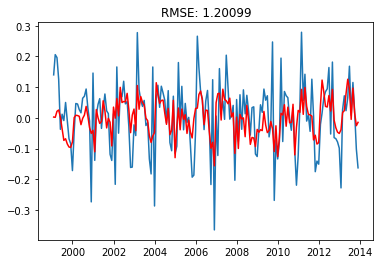

In [106]:
ma_model_prod_log_diff = ARIMA(train_PRODUCTION_log_diff, order=(0, 0, 12))
RESULT_ma_model_prod_log_diff = ma_model_prod_log_diff.fit(disp=-1)
plt.plot(train_PRODUCTION_log_diff)
plt.plot(RESULT_ma_model_prod_log_diff.fittedvalues, color='red')
RMSE_ma_log_diff_opti = np.sqrt(sum((RESULT_ma_model_prod_log_diff.fittedvalues-train_PRODUCTION_log_diff)**2))
plt.title('RMSE: %.5f'% RMSE_ma_log_diff_opti)

### Log Differenced. MA model Optimized. Validation

0.1316145788697285


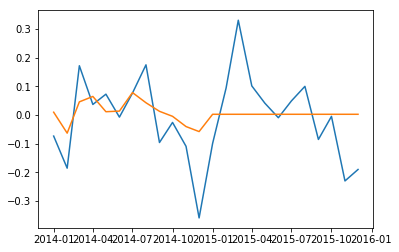

In [107]:
future_preds = RESULT_ma_model_prod_log_diff.predict(start=val_PRODUCTION_log_diff.index[0], end=val_PRODUCTION_log_diff.index[-1])
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_log_diff.index)
future_forecast_p = pd.concat([val_PRODUCTION_log_diff,future_forecast],axis=1)
plt.plot(future_forecast_p)
from sklearn.metrics import mean_squared_error
RMSE_ma_log_diff_opti_val = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_log_diff))
print(RMSE_ma_log_diff_opti_val)

### Log Differenced. ARMA model. Optimization

In [108]:
# Optimization. If you want to check - uncomment
#df_optimized_ARMA = optimize_ARIMA(make_orderlist(product(range(0, 8, 1),range(0, 8, 1)), "ARMA"), exog=train_PRODUCTION_log_diff)
#print(df_optimized_ARMA)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Text(0.5, 1.0, 'RMSE: 1.15785')

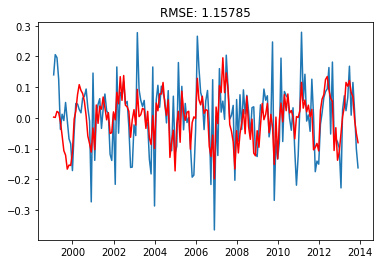

In [109]:
arma_model_prod_log_diff = ARIMA(train_PRODUCTION_log_diff, order=(4, 0, 7))
RESULT_arma_model_prod_log_diff = arma_model_prod_log_diff.fit(disp=-1)
plt.plot(train_PRODUCTION_log_diff)
plt.plot(RESULT_arma_model_prod_log_diff.fittedvalues, color='red')
RMSE_arma_log_diff_opti = np.sqrt(sum((RESULT_arma_model_prod_log_diff.fittedvalues-train_PRODUCTION_log_diff)**2))
plt.title('RMSE: %.5f'% RMSE_arma_log_diff_opti)

### Log Differenced. ARMA model optimized. Validation

0.1370598688207965


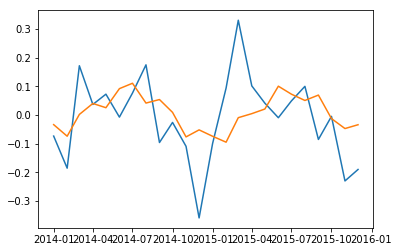

In [110]:
future_preds = RESULT_arma_model_prod_log_diff.predict(start=val_PRODUCTION_log_diff.index[0], end=val_PRODUCTION_log_diff.index[-1])
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_log_diff.index)
future_forecast_p = pd.concat([val_PRODUCTION_log_diff,future_forecast],axis=1)
plt.plot(future_forecast_p)
from sklearn.metrics import mean_squared_error
RMSE_arma_log_diff_opti_val = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_log_diff))
print(RMSE_arma_log_diff_opti_val)

### Log Differenced. ARIMA model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Text(0.5, 1.0, 'RMSE: 1.8706')

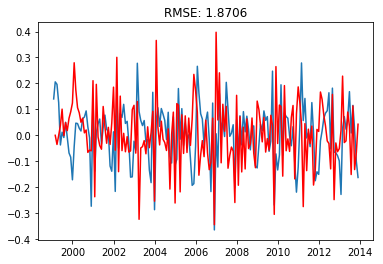

In [111]:
arima_model_prod_log_diff = ARIMA(train_PRODUCTION_log_diff, order=(14, 1, 1))
RESULT_arima_model_prod_log_diff = arima_model_prod_log_diff.fit(disp=-1)
plt.plot(train_PRODUCTION_log_diff)
plt.plot(RESULT_arima_model_prod_log_diff.fittedvalues, color='red')
arr = ((RESULT_arima_model_prod_log_diff.fittedvalues-train_PRODUCTION_log_diff)**2).dropna()
RMSE_arima_log_diff = np.sqrt(sum(arr))
plt.title('RMSE: %.4f'% RMSE_arima_log_diff)

### Log Differenced. ARIMA model. Validation

0.13118197682324947


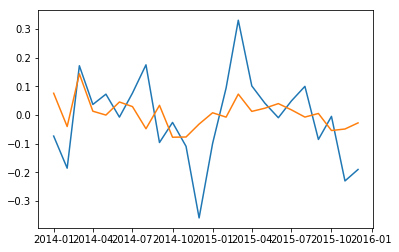

In [112]:
future_preds = RESULT_arima_model_prod_log_diff.predict(start=val_PRODUCTION_log_diff.index[0], end=val_PRODUCTION_log_diff.index[-1])
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_log_diff.index)
future_forecast_p = pd.concat([val_PRODUCTION_log_diff,future_forecast],axis=1)
plt.plot(future_forecast_p)
from sklearn.metrics import mean_squared_error
RMSE_arima_log_diff_val = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_log_diff))
print(RMSE_arima_log_diff_val)

## Comparison of models' RMSE on log differenced data

In [113]:
print("RMSE AR optimized       RMSE AR optimized validation")
print(RMSE_ar_log_diff_opti, "      ", RMSE_ar_log_diff_opti_val)
print("-----------------------------------------------------")
print("RMSE MA optimized       RMSE MA optimized validation")
print(RMSE_ma_log_diff_opti, "      ", RMSE_ma_log_diff_opti_val)
print("-----------------------------------------------------")
print("RMSE ARMA optimized       RMSE ARMA optimized validation")
print(RMSE_arma_log_diff_opti, "      ", RMSE_arma_log_diff_opti_val)
print("-----------------------------------------------------")
print("RMSE ARIMA       RMSE ARMA validation")
print(RMSE_arima_log_diff, "      ", RMSE_arima_log_diff_val)

RMSE AR optimized       RMSE AR optimized validation
1.166480409999918        0.1327024811218064
-----------------------------------------------------
RMSE MA optimized       RMSE MA optimized validation
1.200993145536477        0.1316145788697285
-----------------------------------------------------
RMSE ARMA optimized       RMSE ARMA optimized validation
1.1578521817825296        0.1370598688207965
-----------------------------------------------------
RMSE ARIMA       RMSE ARMA validation
1.8705808178486687        0.13118197682324947


### Multiplicative AR model

In [114]:
#df_optimized_AR = optimize_ARIMA(make_orderlist(range(0, 15, 1), "AR"), exog=train_PRODUCTION_mul)
#print(df_optimized_AR)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 0.8059')

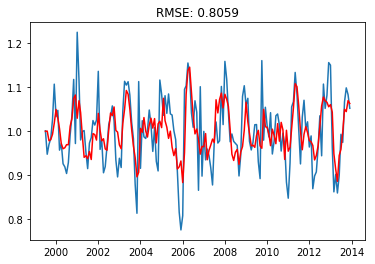

In [115]:
ar_model_prod_mul = ARIMA(train_PRODUCTION_mul, order=(13, 0, 0))
RESULT_ar_model_prod_mul = ar_model_prod_mul.fit(disp=-1)
plt.plot(train_PRODUCTION_mul)
plt.plot(RESULT_ar_model_prod_mul.fittedvalues, color='red')
RMSE_ar_mul_opti = np.sqrt(sum((RESULT_ar_model_prod_mul.fittedvalues-train_PRODUCTION_mul)**2))
plt.title('RMSE: %.4f'% RMSE_ar_mul_opti )

### Multiplicative AR model. Validation

Text(0.5, 1.0, 'RMSE: 0.0959')

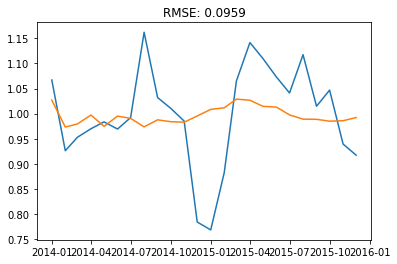

In [116]:
future_preds = RESULT_ar_model_prod_mul.predict(start=val_PRODUCTION_mul.index[0], end=val_PRODUCTION_mul.index[-1])
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_mul.index)
future_forecast_p = pd.concat([val_PRODUCTION_mul,future_forecast],axis=1)
plt.plot(future_forecast_p)
from sklearn.metrics import mean_squared_error
RMSE_ar_mul_val_opti = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_mul))
plt.title('RMSE: %.4f'% RMSE_ar_mul_val_opti )

### Multiplicative MA model

In [117]:
# optimize MA
#df_optimized_MA = optimize_ARIMA(make_orderlist(range(0, 15, 1), "MA"), exog=train_PRODUCTION_mul)
#print(df_optimized_MA)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 0.7965')

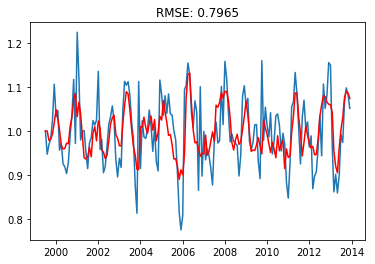

In [118]:
ma_model_prod_mul = ARIMA(train_PRODUCTION_mul, order=(0, 0, 12))
RESULT_ma_model_prod_mul = ma_model_prod_mul.fit(disp=-1)
plt.plot(train_PRODUCTION_mul)
plt.plot(RESULT_ma_model_prod_mul.fittedvalues, color='red')
RMSE_ma_mul_opti = np.sqrt(sum((RESULT_ma_model_prod_mul.fittedvalues-train_PRODUCTION_mul)**2))
plt.title('RMSE: %.4f'% RMSE_ma_mul_opti)

### Multiplicative MA model. Validation

0.09587805897428221


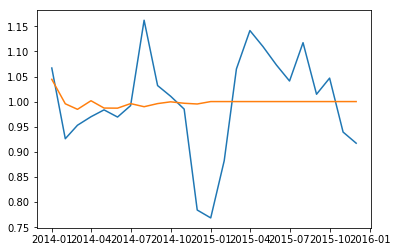

In [119]:
future_preds = RESULT_ma_model_prod_mul.predict(start=val_PRODUCTION_mul.index[0], end=val_PRODUCTION_mul.index[-1])
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_mul.index)
future_forecast_p = pd.concat([val_PRODUCTION_mul,future_forecast],axis=1)
plt.plot(future_forecast_p)
from sklearn.metrics import mean_squared_error
RMSE_ma_mul_opti_val = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_mul))
print(RMSE_ma_mul_opti_val)

### Multiplicative ARMA model. Validation

In [120]:
# optimize ARMA
df_optimized_ARMA = optimize_ARIMA(make_orderlist(product(range(0, 8, 1),range(0, 8, 1)), "ARMA"), exog=train_PRODUCTION_mul)
print(df_optimized_ARMA)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site

    (p, d, q)         AIC
0   (6, 0, 5) -466.598540
1   (5, 0, 3) -466.167771
2   (6, 0, 3) -465.341219
3   (7, 0, 3) -463.455524
4   (7, 0, 5) -463.091807
5   (3, 0, 1) -462.927133
6   (2, 0, 2) -462.485714
7   (4, 0, 1) -462.088284
8   (4, 0, 2) -461.621545
9   (5, 0, 1) -460.432740
10  (3, 0, 3) -460.035395
11  (5, 0, 2) -459.764533
12  (6, 0, 1) -458.444049
13  (6, 0, 2) -458.200813
14  (7, 0, 1) -456.741055
15  (7, 0, 4) -455.195667
16  (7, 0, 2) -454.885665
17  (2, 0, 1) -450.255183
18  (0, 0, 6) -449.877257
19  (0, 0, 7) -449.247392
20  (0, 0, 5) -441.671952
21  (6, 0, 0) -438.220355
22  (7, 0, 0) -438.085178
23  (5, 0, 0) -437.899906
24  (4, 0, 0) -435.053216
25  (0, 0, 3) -424.593159
26  (3, 0, 0) -424.305703
27  (0, 0, 4) -422.605845
28  (1, 0, 2) -421.944279
29  (1, 0, 0) -421.304722
30  (0, 0, 2) -421.178638
31  (2, 0, 0) -419.636457
32  (1, 0, 1) -419.475226
33  (0, 0, 1) -412.130798
34  (0, 0, 0) -385.832922


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 0.7708')

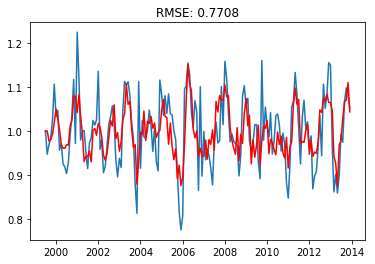

In [121]:
arma_model_prod_mul = ARIMA(train_PRODUCTION_mul, order=(6, 0, 5))
RESULT_arma_model_prod_mul = arma_model_prod_mul.fit(disp=-1)
plt.plot(train_PRODUCTION_mul)
plt.plot(RESULT_arma_model_prod_mul.fittedvalues, color='red')
RMSE_arma_mul_opti = np.sqrt(sum((RESULT_arma_model_prod_mul.fittedvalues-train_PRODUCTION_mul)**2))
plt.title('RMSE: %.4f'% RMSE_arma_mul_opti)

### Multiplicative. ARMA model. Validation

0.0985981251884435


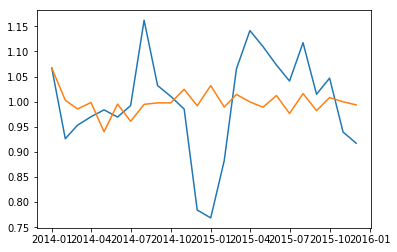

In [122]:
future_preds = RESULT_arma_model_prod_mul.predict(start=val_PRODUCTION_mul.index[0], end=val_PRODUCTION_mul.index[-1])
future_forecast = pd.DataFrame(future_preds,index = val_PRODUCTION_mul.index)
future_forecast_p = pd.concat([val_PRODUCTION_mul,future_forecast],axis=1)
plt.plot(future_forecast_p)
from sklearn.metrics import mean_squared_error
RMSE_arma_mul_opti_val = np.sqrt(mean_squared_error(future_forecast, val_PRODUCTION_mul))
print(RMSE_arma_mul_opti_val)

In [123]:
print("RMSE AR optimized       RMSE AR optimized validation")
print(RMSE_ar_mul_opti, "      ", RMSE_ar_mul_val_opti)
print("-----------------------------------------------------")
print("RMSE MA optimized       RMSE MA optimized validation")
print(RMSE_ma_mul_opti, "      ", RMSE_ma_mul_opti_val)
print("-----------------------------------------------------")
print("RMSE ARMA optimized       RMSE ARMA optimized validation")
print(RMSE_arma_mul_opti, "      ", RMSE_arma_mul_opti_val)
print("-----------------------------------------------------")

RMSE AR optimized       RMSE AR optimized validation
0.8058609096143058        0.09587563357851661
-----------------------------------------------------
RMSE MA optimized       RMSE MA optimized validation
0.7964805325519435        0.09587805897428221
-----------------------------------------------------
RMSE ARMA optimized       RMSE ARMA optimized validation
0.7708105277576885        0.0985981251884435
-----------------------------------------------------


## Visulization

In [124]:
## TESTing

## Testing MA on additive logarithmic data

In [125]:
df = [train_PRODUCTION_log_add, val_PRODUCTION_log_add]
df = pd.concat(df)
ma_model_prod_log_add = ARIMA(df, order=(0, 0, 12))
RESULT_ma_model_log_add = ma_model_prod_log_add.fit(disp=-1)
plt.plot(df)
plt.plot(RESULT_ma_model_log_add.fittedvalues, color='red')
RMSE_ma_model_log_add_test = np.sqrt(sum((RESULT_ma_model_log_add.fittedvalues-df)**2))
plt.title('RMSE: %.5f'% RMSE_ma_model_log_add_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


KeyboardInterrupt: 

In [ ]:
future_preds_log_add = RESULT_ma_model_log_add.predict(start=test_PRODUCTION_log_add.index[0], end=test_PRODUCTION_log_add.index[-1])
future_preds_log_add = pd.DataFrame(future_preds_log_add,index = test_PRODUCTION_log_add.index)
future_preds_log_add_p = pd.concat([test_PRODUCTION_log_add,future_preds_log_add],axis=1)
plt.plot(future_preds_log_add_p)

from sklearn.metrics import mean_squared_error
RMSE_ma_log_add_test = np.sqrt(mean_squared_error(np.exp(future_preds_log_add), np.exp(test_PRODUCTION_log_add)))
print(RMSE_ma_log_add_test)

### Testing ARMA on additive logarithmic data

In [ ]:
df = [train_PRODUCTION_log_add, val_PRODUCTION_log_add]
df = pd.concat(df)
arma_model_prod_log_add = ARIMA(df, order=(5, 0, 3))
RESULT_arma_model_log_add = arma_model_prod_log_add.fit(disp=-1)
plt.plot(df)
plt.plot(RESULT_arma_model_log_add.fittedvalues, color='red')
RMSE_arma_model_log_add_test = np.sqrt(sum((RESULT_arma_model_log_add.fittedvalues-df)**2))
plt.title('RMSE: %.5f'% RMSE_arma_model_log_add_test)

In [ ]:
future_preds_log_add = RESULT_arma_model_log_add.predict(start=test_PRODUCTION_log_add.index[0], end=test_PRODUCTION_log_add.index[-1])
future_preds_log_add = pd.DataFrame(future_preds_log_add,index = test_PRODUCTION_log_add.index)
future_preds_log_add_p = pd.concat([test_PRODUCTION_log_add,future_preds_log_add],axis=1)
plt.plot(future_preds_log_add_p)

from sklearn.metrics import mean_squared_error
RMSE_arma_log_add_test = np.sqrt(mean_squared_error(np.exp(future_preds_log_add), np.exp(test_PRODUCTION_log_add)))
print(RMSE_arma_log_add_test)

## Testing MA on log differenced data

In [ ]:
df = [train_PRODUCTION_log_diff, val_PRODUCTION_log_diff]
df = pd.concat(df)
ma_model_prod_log_diff = ARIMA(df, order=(0, 0, 12))
RESULT_ma_model_log_diff = ma_model_prod_log_diff.fit(disp=-1)
plt.plot(df)
plt.plot(RESULT_ma_model_log_diff.fittedvalues, color='red')
RMSE_ma_model_log_diff_test = np.sqrt(sum((RESULT_ma_model_log_diff.fittedvalues-df)**2))
plt.title('RMSE: %.5f'% RMSE_ma_model_log_diff_test)

In [ ]:
future_preds_log_diff = RESULT_ma_model_log_diff.predict(start=test_PRODUCTION_log_diff.index[0], end=test_PRODUCTION_log_diff.index[-1])
future_preds_log_diff = pd.DataFrame(future_preds_log_diff,index = test_PRODUCTION_log_diff.index)
future_preds_log_diff_p = pd.concat([test_PRODUCTION_log_diff,future_preds_log_diff],axis=1)
plt.plot(future_preds_log_diff_p)

from sklearn.metrics import mean_squared_error
RMSE_ma_log_diff_test = np.sqrt(mean_squared_error(np.exp(future_preds_log_diff), np.exp(test_PRODUCTION_log_diff)))
print(RMSE_ma_log_diff_test)

### Testing AR on log differenced data

In [ ]:
df = [train_PRODUCTION_log_diff, val_PRODUCTION_log_diff]
df = pd.concat(df)
ar_model_prod_log_diff = ARIMA(df, order=(13, 0, 0))
RESULT_ar_model_log_diff = ar_model_prod_log_diff.fit(disp=-1)
plt.plot(df)
plt.plot(RESULT_ar_model_log_diff.fittedvalues, color='red')
RMSE_ar_model_log_diff_test = np.sqrt(sum((RESULT_ar_model_log_diff.fittedvalues-df)**2))
plt.title('RMSE: %.5f'% RMSE_ar_model_log_diff_test)

In [ ]:
future_preds_log_diff = RESULT_ar_model_log_diff.predict(start=test_PRODUCTION_log_diff.index[0], end=test_PRODUCTION_log_diff.index[-1])
future_preds_log_diff = pd.DataFrame(future_preds_log_diff,index = test_PRODUCTION_log_diff.index)
future_preds_log_diff_p = pd.concat([test_PRODUCTION_log_diff,future_preds_log_diff],axis=1)
plt.plot(future_preds_log_diff_p)

from sklearn.metrics import mean_squared_error
RMSE_ar_log_diff_test = np.sqrt(mean_squared_error(np.exp(future_preds_log_diff), np.exp(test_PRODUCTION_log_diff)))
print(RMSE_ar_log_diff_test)

### Testing ARMA on Multiplicative data

In [ ]:
df = [train_PRODUCTION_mul, val_PRODUCTION_mul]
df = pd.concat(df)
arma_model_prod_mul = ARIMA(df, order=(6, 0, 5))
RESULT_arma_model_mul = arma_model_prod_mul.fit(disp=-1)
plt.plot(df)
plt.plot(RESULT_arma_model_mul.fittedvalues, color='red')
RMSE_arma_model_mul_test = np.sqrt(sum((RESULT_arma_model_mul.fittedvalues-df)**2))
plt.title('RMSE: %.5f'% RMSE_arma_model_mul_test)

In [ ]:
future_preds_mul = RESULT_arma_model_mul.predict(start=test_PRODUCTION_mul.index[0], end=test_PRODUCTION_mul.index[-1])
future_preds_mul = pd.DataFrame(future_preds_mul ,index = test_PRODUCTION_mul.index)
future_preds_mul_p = pd.concat([test_PRODUCTION_mul ,future_preds_mul],axis=1)
plt.plot(future_preds_mul_p)

from sklearn.metrics import mean_squared_error
RMSE_arma_mul_test = np.sqrt(mean_squared_error(np.exp(future_preds_mul), np.exp(test_PRODUCTION_mul)))
print(RMSE_arma_mul_test)

## Comparison of Models after TESTING

In [ ]:
print("RMSE MA on log additive      RMSE MA validation")
print(RMSE_ma_model_log_add_test, "      ", RMSE_ma_log_add_test)
print("-----------------------------------------------------")
print("RMSE ARMA on log additive      RMSE ARMA validation")
print(RMSE_arma_model_log_add_test, "      ", RMSE_arma_log_add_test)
print("-----------------------------------------------------")
print("RMSE MA on log differenced       RMSE MA validation")
print(RMSE_ma_model_log_diff_test, "      ", RMSE_ma_log_diff_test)
print("-----------------------------------------------------")
print("RMSE AR on log differenced       RMSE AR validation")
print(RMSE_ar_model_log_diff_test, "      ", RMSE_ar_log_diff_test)
print("-----------------------------------------------------")
print("RMSE ARMA on multiplicative       RMSE ARMA validation")
print(RMSE_arma_model_mul_test, "      ", RMSE_arma_mul_test)

In [ ]:
x_units = [1, 2, 4, 5, 7, 8, 10, 11, 13, 14]

y_units = [RMSE_ma_model_log_add_test, RMSE_ma_log_add_test, RMSE_arma_model_log_add_test, RMSE_arma_log_add_test, RMSE_ma_model_log_diff_test, RMSE_ma_log_diff_test, 
        RMSE_ar_model_log_diff_test, RMSE_ar_log_diff_test, RMSE_arma_model_mul_test, RMSE_arma_mul_test]

tick_label = ['MA logadd', '    ', 'ARMA logadd', '  ', 'MA logdiff', '  ', 'AR logdiff', 
             '  ', 'ARMAmul', '  ']

plt.bar(x_units, y_units, tick_label=tick_label, color=['lightblue', 'lightpink'])

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Performance of models on Logarithmic Additive Decomposed data')

plt.show()

On testing the best performing models is ARMA which shows good result both with logarithmic data, multiplicative and additive decomposed.

## Facebook Prophet

In [126]:
from fbprophet import Prophet

In [127]:
m = Prophet(seasonality_mode='multiplicative',
            growth='linear')
m.add_seasonality(name='monthly', period=4, fourier_order=20)


In [128]:
train_log_add_df = pd.DataFrame({
    'ds': train_PRODUCTION_log_add.index,
    'y': train_PRODUCTION_log_add.values})

train_log_add_df['floor'] = train_log_add_df['y'].min()
train_log_add_df['cap'] = train_log_add_df['y'].max() + (train_log_add_df['y'].max() *0.2)


In [129]:
m.fit(train_log_add_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [130]:
future = m.make_future_dataframe(periods=1, include_history=True, freq="y")

In [131]:
future['floor'] = train_log_add_df['y'].min()
future['cap'] = train_log_add_df['y'].max() + (train_log_add_df['y'].max() *0.2)


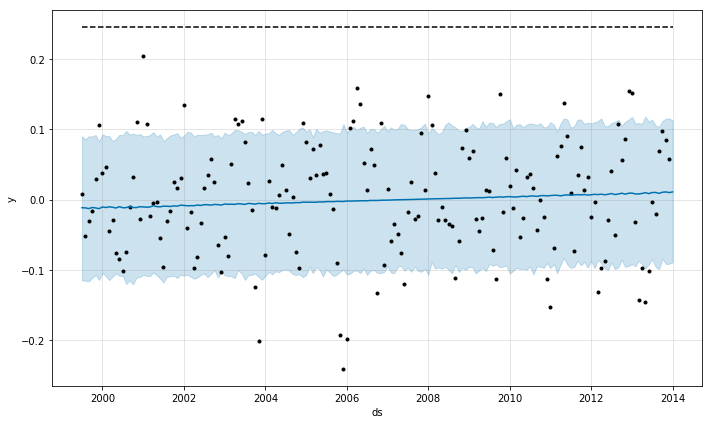

In [132]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

fig1 = m.plot(forecast)

In [133]:
mul_model_or = Prophet(seasonality_mode='additive',
            growth='linear',
                      yearly_seasonality=True,
            weekly_seasonality=True)
mul_model_or.add_seasonality(name='monthly', period=4, fourier_order=5)
train_or_df = pd.DataFrame({
    'ds': PRODUCTION.index,
    'y': np.log(PRODUCTION.values)})

train_or_df['floor'] = train_or_df['y'].min()
train_or_df['cap'] = train_or_df['y'].max() + (train_or_df['y'].max() *0.2)
print(train_or_df)

            ds         y     floor      cap
0   1999-01-01  5.897667  5.897667  8.43617
1   1999-02-01  6.037842  5.897667  8.43617
2   1999-03-01  6.243837  5.897667  8.43617
3   1999-04-01  6.440208  5.897667  8.43617
4   1999-05-01  6.566449  5.897667  8.43617
..         ...       ...       ...      ...
220 2017-05-01  6.762807  5.897667  8.43617
221 2017-06-01  6.633384  5.897667  8.43617
222 2017-07-01  6.894463  5.897667  8.43617
223 2017-08-01  6.887937  5.897667  8.43617
224 2017-09-01  6.877492  5.897667  8.43617

[225 rows x 4 columns]


In [134]:
mul_model_or.fit(train_or_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [135]:
#future = mul_model_add.make_future_dataframe(periods=12, freq='m')
#future.tail()

In [136]:
future = mul_model_or.make_future_dataframe(periods=12, include_history=True, freq="m")
future['floor'] = train_or_df['y'].min()
future['cap'] = train_or_df['y'].max() + (train_or_df['y'].max() *0.2)


In [137]:
forecast = mul_model_or.predict(future)

In [138]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
232,2018-04-30,6.693244,6.574430,6.809574
233,2018-05-31,6.605019,6.482209,6.731308
234,2018-06-30,6.722906,6.600775,6.853779
235,2018-07-31,6.863029,6.740810,6.984178
236,2018-08-31,6.795207,6.677711,6.911977


,yhat,yhat_lower,yhat_upper
0,470.698308,415.809620,528.753169
1,466.498795,413.695009,533.449233
2,554.551936,488.853405,635.282253
3,571.157845,500.746671,645.116890
4,618.483712,545.095648,697.554813
...,...,...,...
232,806.935949,716.537000,906.484863
233,738.794014,653.412974,838.243378
234,831.229776,735.664869,947.454907
235,956.259653,846.245745,1079.419072


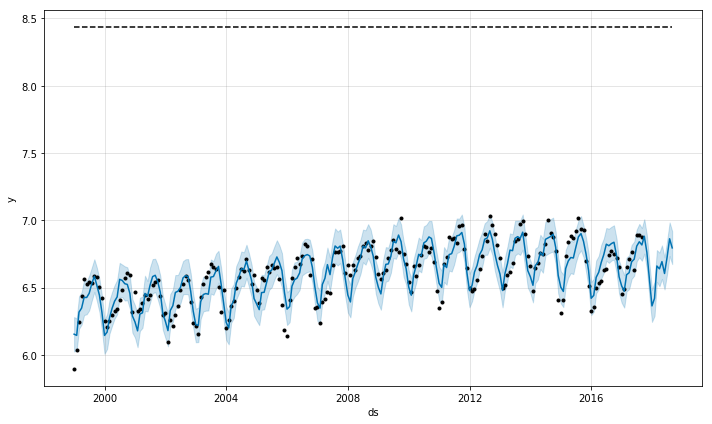

In [166]:
fig1 = mul_model_or.plot(forecast)

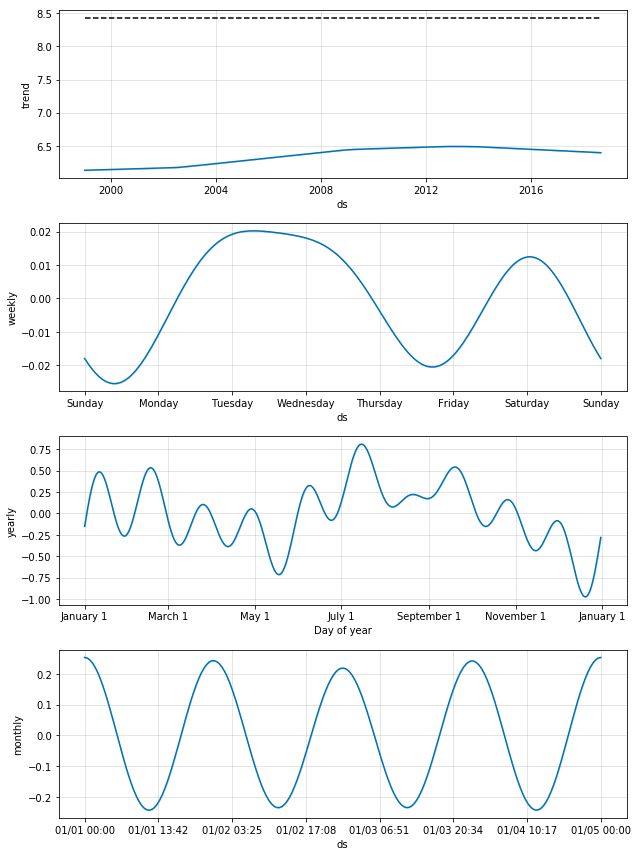

In [167]:
mul_model_or.plot_components(forecast);

## DL

In [144]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, RepeatVector
from keras.layers import LSTM
from keras.optimizers import Adam, Adagrad

from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe, rand

In [145]:
values = np.concatenate((DATA_DF.values, PRODUCTION.values.reshape((-1, 1))), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

In [146]:
VALIDATION_SHIFT = 12
EPOCHS = 200

train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

optimizer = Adagrad(0.01)

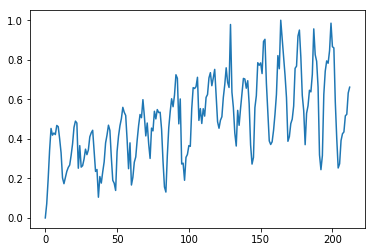

In [172]:
plt.plot(train_y)

### With Mean squared logarithmic loss function

Epoch 1/200
4/4 - 1s - loss: 0.0517 - val_loss: 0.0425
Epoch 2/200
4/4 - 0s - loss: 0.0327 - val_loss: 0.0253
Epoch 3/200
4/4 - 0s - loss: 0.0219 - val_loss: 0.0144
Epoch 4/200
4/4 - 0s - loss: 0.0142 - val_loss: 0.0081
Epoch 5/200
4/4 - 0s - loss: 0.0129 - val_loss: 0.0053
Epoch 6/200
4/4 - 0s - loss: 0.0123 - val_loss: 0.0042
Epoch 7/200
4/4 - 0s - loss: 0.0127 - val_loss: 0.0039
Epoch 8/200
4/4 - 0s - loss: 0.0131 - val_loss: 0.0038
Epoch 9/200
4/4 - 0s - loss: 0.0126 - val_loss: 0.0040
Epoch 10/200
4/4 - 0s - loss: 0.0135 - val_loss: 0.0043
Epoch 11/200
4/4 - 0s - loss: 0.0110 - val_loss: 0.0047
Epoch 12/200
4/4 - 0s - loss: 0.0115 - val_loss: 0.0051
Epoch 13/200
4/4 - 0s - loss: 0.0113 - val_loss: 0.0055
Epoch 14/200
4/4 - 0s - loss: 0.0106 - val_loss: 0.0057
Epoch 15/200
4/4 - 0s - loss: 0.0113 - val_loss: 0.0058
Epoch 16/200
4/4 - 0s - loss: 0.0129 - val_loss: 0.0055
Epoch 17/200
4/4 - 0s - loss: 0.0108 - val_loss: 0.0050
Epoch 18/200
4/4 - 0s - loss: 0.0106 - val_loss: 0.0046
E

Epoch 147/200
4/4 - 0s - loss: 0.0061 - val_loss: 0.0050
Epoch 148/200
4/4 - 0s - loss: 0.0056 - val_loss: 0.0054
Epoch 149/200
4/4 - 0s - loss: 0.0057 - val_loss: 0.0059
Epoch 150/200
4/4 - 0s - loss: 0.0061 - val_loss: 0.0059
Epoch 151/200
4/4 - 0s - loss: 0.0063 - val_loss: 0.0054
Epoch 152/200
4/4 - 0s - loss: 0.0056 - val_loss: 0.0048
Epoch 153/200
4/4 - 0s - loss: 0.0059 - val_loss: 0.0045
Epoch 154/200
4/4 - 0s - loss: 0.0060 - val_loss: 0.0051
Epoch 155/200
4/4 - 0s - loss: 0.0056 - val_loss: 0.0058
Epoch 156/200
4/4 - 0s - loss: 0.0052 - val_loss: 0.0054
Epoch 157/200
4/4 - 0s - loss: 0.0055 - val_loss: 0.0047
Epoch 158/200
4/4 - 0s - loss: 0.0061 - val_loss: 0.0046
Epoch 159/200
4/4 - 0s - loss: 0.0056 - val_loss: 0.0052
Epoch 160/200
4/4 - 0s - loss: 0.0061 - val_loss: 0.0058
Epoch 161/200
4/4 - 0s - loss: 0.0053 - val_loss: 0.0063
Epoch 162/200
4/4 - 0s - loss: 0.0060 - val_loss: 0.0062
Epoch 163/200
4/4 - 0s - loss: 0.0054 - val_loss: 0.0057
Epoch 164/200
4/4 - 0s - loss: 

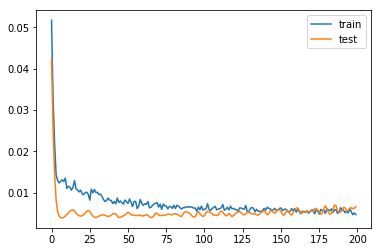

Train: 0.004, Test: 0.007


In [173]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#model.add(Dense(25, activation='linear'))
model.add(Dense(1, activation='relu'))
#model.compile(loss='mae', optimizer=optimizer)
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, 
                    epochs=EPOCHS, batch_size=64, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

train_mse = model.evaluate(train_X, train_y, verbose=0)
test_mse = model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# make a prediction
yhat = model.predict(test_X)
yhat[yhat<0] = 0
yhat_train = model.predict(train_X)
yhat_train[yhat_train<0] = 0

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

In [174]:
### dense hidden layer

Epoch 1/200
4/4 - 0s - loss: 0.0926 - val_loss: 0.0200
Epoch 2/200
4/4 - 0s - loss: 0.0873 - val_loss: 0.0170
Epoch 3/200
4/4 - 0s - loss: 0.0934 - val_loss: 0.0154
Epoch 4/200
4/4 - 0s - loss: 0.0714 - val_loss: 0.0159
Epoch 5/200
4/4 - 0s - loss: 0.0731 - val_loss: 0.0144
Epoch 6/200
4/4 - 0s - loss: 0.0694 - val_loss: 0.0096
Epoch 7/200
4/4 - 0s - loss: 0.0625 - val_loss: 0.0066
Epoch 8/200
4/4 - 0s - loss: 0.0693 - val_loss: 0.0059
Epoch 9/200
4/4 - 0s - loss: 0.0595 - val_loss: 0.0052
Epoch 10/200
4/4 - 0s - loss: 0.0507 - val_loss: 0.0045
Epoch 11/200
4/4 - 0s - loss: 0.0493 - val_loss: 0.0051
Epoch 12/200
4/4 - 0s - loss: 0.0567 - val_loss: 0.0068
Epoch 13/200
4/4 - 0s - loss: 0.0440 - val_loss: 0.0045
Epoch 14/200
4/4 - 0s - loss: 0.0440 - val_loss: 0.0038
Epoch 15/200
4/4 - 0s - loss: 0.0404 - val_loss: 0.0035
Epoch 16/200
4/4 - 0s - loss: 0.0443 - val_loss: 0.0034
Epoch 17/200
4/4 - 0s - loss: 0.0421 - val_loss: 0.0034
Epoch 18/200
4/4 - 0s - loss: 0.0317 - val_loss: 0.0032
E

Epoch 147/200
4/4 - 0s - loss: 0.0085 - val_loss: 0.0058
Epoch 148/200
4/4 - 0s - loss: 0.0076 - val_loss: 0.0059
Epoch 149/200
4/4 - 0s - loss: 0.0078 - val_loss: 0.0063
Epoch 150/200
4/4 - 0s - loss: 0.0080 - val_loss: 0.0056
Epoch 151/200
4/4 - 0s - loss: 0.0078 - val_loss: 0.0046
Epoch 152/200
4/4 - 0s - loss: 0.0092 - val_loss: 0.0065
Epoch 153/200
4/4 - 0s - loss: 0.0086 - val_loss: 0.0075
Epoch 154/200
4/4 - 0s - loss: 0.0070 - val_loss: 0.0063
Epoch 155/200
4/4 - 0s - loss: 0.0081 - val_loss: 0.0057
Epoch 156/200
4/4 - 0s - loss: 0.0082 - val_loss: 0.0070
Epoch 157/200
4/4 - 0s - loss: 0.0095 - val_loss: 0.0083
Epoch 158/200
4/4 - 0s - loss: 0.0081 - val_loss: 0.0064
Epoch 159/200
4/4 - 0s - loss: 0.0073 - val_loss: 0.0055
Epoch 160/200
4/4 - 0s - loss: 0.0095 - val_loss: 0.0051
Epoch 161/200
4/4 - 0s - loss: 0.0067 - val_loss: 0.0064
Epoch 162/200
4/4 - 0s - loss: 0.0078 - val_loss: 0.0080
Epoch 163/200
4/4 - 0s - loss: 0.0086 - val_loss: 0.0060
Epoch 164/200
4/4 - 0s - loss: 

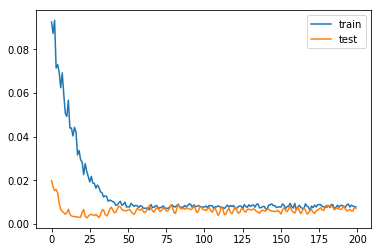

Train: 0.006, Test: 0.007


In [175]:
values = np.concatenate((DATA_DF.values, PRODUCTION.values.reshape((-1, 1))), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

VALIDATION_SHIFT = 12
EPOCHS = 200

train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

model = Sequential()
#model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(25, activation='linear'))
model.add(Dense(1, activation='relu'))
#model.compile(loss='mae', optimizer=optimizer)
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, 
                    epochs=EPOCHS, batch_size=64, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

train_mse = model.evaluate(train_X, train_y, verbose=0)
test_mse = model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# make a prediction
yhat = model.predict(test_X)
yhat[yhat<0] = 0
yhat_train = model.predict(train_X)
yhat_train[yhat_train<0] = 0

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

In [176]:
### dense hidden layer + lstm

Epoch 1/200
4/4 - 0s - loss: 0.1208 - val_loss: 0.1084
Epoch 2/200
4/4 - 0s - loss: 0.0692 - val_loss: 0.0621
Epoch 3/200
4/4 - 0s - loss: 0.0392 - val_loss: 0.0323
Epoch 4/200
4/4 - 0s - loss: 0.0236 - val_loss: 0.0151
Epoch 5/200
4/4 - 0s - loss: 0.0149 - val_loss: 0.0069
Epoch 6/200
4/4 - 0s - loss: 0.0136 - val_loss: 0.0042
Epoch 7/200
4/4 - 0s - loss: 0.0151 - val_loss: 0.0037
Epoch 8/200
4/4 - 0s - loss: 0.0151 - val_loss: 0.0037
Epoch 9/200
4/4 - 0s - loss: 0.0145 - val_loss: 0.0037
Epoch 10/200
4/4 - 0s - loss: 0.0137 - val_loss: 0.0042
Epoch 11/200
4/4 - 0s - loss: 0.0132 - val_loss: 0.0051
Epoch 12/200
4/4 - 0s - loss: 0.0119 - val_loss: 0.0063
Epoch 13/200
4/4 - 0s - loss: 0.0129 - val_loss: 0.0070
Epoch 14/200
4/4 - 0s - loss: 0.0129 - val_loss: 0.0073
Epoch 15/200
4/4 - 0s - loss: 0.0121 - val_loss: 0.0071
Epoch 16/200
4/4 - 0s - loss: 0.0107 - val_loss: 0.0066
Epoch 17/200
4/4 - 0s - loss: 0.0115 - val_loss: 0.0061
Epoch 18/200
4/4 - 0s - loss: 0.0105 - val_loss: 0.0057
E

Epoch 147/200
4/4 - 0s - loss: 0.0061 - val_loss: 0.0043
Epoch 148/200
4/4 - 0s - loss: 0.0061 - val_loss: 0.0044
Epoch 149/200
4/4 - 0s - loss: 0.0062 - val_loss: 0.0050
Epoch 150/200
4/4 - 0s - loss: 0.0057 - val_loss: 0.0052
Epoch 151/200
4/4 - 0s - loss: 0.0063 - val_loss: 0.0046
Epoch 152/200
4/4 - 0s - loss: 0.0058 - val_loss: 0.0040
Epoch 153/200
4/4 - 0s - loss: 0.0056 - val_loss: 0.0042
Epoch 154/200
4/4 - 0s - loss: 0.0051 - val_loss: 0.0048
Epoch 155/200
4/4 - 0s - loss: 0.0056 - val_loss: 0.0055
Epoch 156/200
4/4 - 0s - loss: 0.0057 - val_loss: 0.0054
Epoch 157/200
4/4 - 0s - loss: 0.0058 - val_loss: 0.0045
Epoch 158/200
4/4 - 0s - loss: 0.0057 - val_loss: 0.0043
Epoch 159/200
4/4 - 0s - loss: 0.0059 - val_loss: 0.0049
Epoch 160/200
4/4 - 0s - loss: 0.0055 - val_loss: 0.0054
Epoch 161/200
4/4 - 0s - loss: 0.0057 - val_loss: 0.0055
Epoch 162/200
4/4 - 0s - loss: 0.0057 - val_loss: 0.0053
Epoch 163/200
4/4 - 0s - loss: 0.0058 - val_loss: 0.0052
Epoch 164/200
4/4 - 0s - loss: 

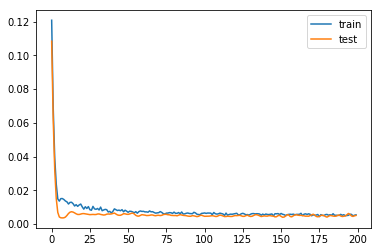

Train: 0.004, Test: 0.005


In [177]:
values = np.concatenate((DATA_DF.values, PRODUCTION.values.reshape((-1, 1))), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

VALIDATION_SHIFT = 12
EPOCHS = 200

train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

optimizer = Adagrad(0.01)

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(25, activation='linear'))
model.add(Dense(1, activation='relu'))
#model.compile(loss='mae', optimizer=optimizer)
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, 
                    epochs=EPOCHS, batch_size=64, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

train_mse = model.evaluate(train_X, train_y, verbose=0)
test_mse = model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# make a prediction
yhat = model.predict(test_X)
yhat[yhat<0] = 0
yhat_train = model.predict(train_X)
yhat_train[yhat_train<0] = 0

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

### With Mean squared loss function

Epoch 1/200
4/4 - 0s - loss: 0.1962 - val_loss: 0.1777
Epoch 2/200
4/4 - 0s - loss: 0.1379 - val_loss: 0.1204
Epoch 3/200
4/4 - 0s - loss: 0.0929 - val_loss: 0.0759
Epoch 4/200
4/4 - 0s - loss: 0.0607 - val_loss: 0.0444
Epoch 5/200
4/4 - 0s - loss: 0.0433 - val_loss: 0.0250
Epoch 6/200
4/4 - 0s - loss: 0.0333 - val_loss: 0.0153
Epoch 7/200
4/4 - 0s - loss: 0.0312 - val_loss: 0.0115
Epoch 8/200
4/4 - 0s - loss: 0.0333 - val_loss: 0.0105
Epoch 9/200
4/4 - 0s - loss: 0.0290 - val_loss: 0.0102
Epoch 10/200
4/4 - 0s - loss: 0.0290 - val_loss: 0.0102
Epoch 11/200
4/4 - 0s - loss: 0.0298 - val_loss: 0.0108
Epoch 12/200
4/4 - 0s - loss: 0.0313 - val_loss: 0.0119
Epoch 13/200
4/4 - 0s - loss: 0.0250 - val_loss: 0.0134
Epoch 14/200
4/4 - 0s - loss: 0.0237 - val_loss: 0.0143
Epoch 15/200
4/4 - 0s - loss: 0.0246 - val_loss: 0.0145
Epoch 16/200
4/4 - 0s - loss: 0.0274 - val_loss: 0.0143
Epoch 17/200
4/4 - 0s - loss: 0.0269 - val_loss: 0.0138
Epoch 18/200
4/4 - 0s - loss: 0.0245 - val_loss: 0.0130
E

Epoch 147/200
4/4 - 0s - loss: 0.0150 - val_loss: 0.0092
Epoch 148/200
4/4 - 0s - loss: 0.0144 - val_loss: 0.0083
Epoch 149/200
4/4 - 0s - loss: 0.0131 - val_loss: 0.0083
Epoch 150/200
4/4 - 0s - loss: 0.0134 - val_loss: 0.0089
Epoch 151/200
4/4 - 0s - loss: 0.0131 - val_loss: 0.0089
Epoch 152/200
4/4 - 0s - loss: 0.0146 - val_loss: 0.0084
Epoch 153/200
4/4 - 0s - loss: 0.0133 - val_loss: 0.0076
Epoch 154/200
4/4 - 0s - loss: 0.0129 - val_loss: 0.0072
Epoch 155/200
4/4 - 0s - loss: 0.0130 - val_loss: 0.0081
Epoch 156/200
4/4 - 0s - loss: 0.0111 - val_loss: 0.0092
Epoch 157/200
4/4 - 0s - loss: 0.0145 - val_loss: 0.0094
Epoch 158/200
4/4 - 0s - loss: 0.0136 - val_loss: 0.0086
Epoch 159/200
4/4 - 0s - loss: 0.0135 - val_loss: 0.0080
Epoch 160/200
4/4 - 0s - loss: 0.0132 - val_loss: 0.0086
Epoch 161/200
4/4 - 0s - loss: 0.0110 - val_loss: 0.0096
Epoch 162/200
4/4 - 0s - loss: 0.0138 - val_loss: 0.0107
Epoch 163/200
4/4 - 0s - loss: 0.0144 - val_loss: 0.0103
Epoch 164/200
4/4 - 0s - loss: 

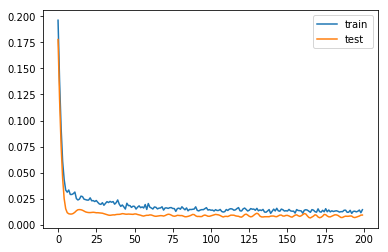

Train: 0.009, Test: 0.009


In [178]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#model.add(Dense(25, activation='linear'))
model.add(Dense(1, activation='relu'))
#model.compile(loss='mae', optimizer=optimizer)
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, 
                    epochs=EPOCHS, batch_size=64, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

train_mse = model.evaluate(train_X, train_y, verbose=0)
test_mse = model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# make a prediction
yhat = model.predict(test_X)
yhat[yhat<0] = 0
yhat_train = model.predict(train_X)
yhat_train[yhat_train<0] = 0

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

In [179]:
### THE BEST:

Epoch 1/200
4/4 - 1s - loss: 0.1019 - val_loss: 0.0945
Epoch 2/200
4/4 - 0s - loss: 0.0706 - val_loss: 0.0610
Epoch 3/200
4/4 - 0s - loss: 0.0420 - val_loss: 0.0372
Epoch 4/200
4/4 - 0s - loss: 0.0241 - val_loss: 0.0218
Epoch 5/200
4/4 - 0s - loss: 0.0176 - val_loss: 0.0125
Epoch 6/200
4/4 - 0s - loss: 0.0135 - val_loss: 0.0076
Epoch 7/200
4/4 - 0s - loss: 0.0134 - val_loss: 0.0054
Epoch 8/200
4/4 - 0s - loss: 0.0114 - val_loss: 0.0044
Epoch 9/200
4/4 - 0s - loss: 0.0139 - val_loss: 0.0041
Epoch 10/200
4/4 - 0s - loss: 0.0120 - val_loss: 0.0041
Epoch 11/200
4/4 - 0s - loss: 0.0126 - val_loss: 0.0042
Epoch 12/200
4/4 - 0s - loss: 0.0110 - val_loss: 0.0044
Epoch 13/200
4/4 - 0s - loss: 0.0110 - val_loss: 0.0047
Epoch 14/200
4/4 - 0s - loss: 0.0108 - val_loss: 0.0050
Epoch 15/200
4/4 - 0s - loss: 0.0103 - val_loss: 0.0053
Epoch 16/200
4/4 - 0s - loss: 0.0115 - val_loss: 0.0056
Epoch 17/200
4/4 - 0s - loss: 0.0109 - val_loss: 0.0058
Epoch 18/200
4/4 - 0s - loss: 0.0117 - val_loss: 0.0061
E

Epoch 147/200
4/4 - 0s - loss: 0.0060 - val_loss: 0.0060
Epoch 148/200
4/4 - 0s - loss: 0.0056 - val_loss: 0.0064
Epoch 149/200
4/4 - 0s - loss: 0.0063 - val_loss: 0.0065
Epoch 150/200
4/4 - 0s - loss: 0.0062 - val_loss: 0.0063
Epoch 151/200
4/4 - 0s - loss: 0.0061 - val_loss: 0.0062
Epoch 152/200
4/4 - 0s - loss: 0.0064 - val_loss: 0.0064
Epoch 153/200
4/4 - 0s - loss: 0.0062 - val_loss: 0.0065
Epoch 154/200
4/4 - 0s - loss: 0.0059 - val_loss: 0.0070
Epoch 155/200
4/4 - 0s - loss: 0.0059 - val_loss: 0.0071
Epoch 156/200
4/4 - 0s - loss: 0.0064 - val_loss: 0.0066
Epoch 157/200
4/4 - 0s - loss: 0.0063 - val_loss: 0.0061
Epoch 158/200
4/4 - 0s - loss: 0.0058 - val_loss: 0.0057
Epoch 159/200
4/4 - 0s - loss: 0.0059 - val_loss: 0.0058
Epoch 160/200
4/4 - 0s - loss: 0.0061 - val_loss: 0.0062
Epoch 161/200
4/4 - 0s - loss: 0.0055 - val_loss: 0.0064
Epoch 162/200
4/4 - 0s - loss: 0.0059 - val_loss: 0.0062
Epoch 163/200
4/4 - 0s - loss: 0.0062 - val_loss: 0.0061
Epoch 164/200
4/4 - 0s - loss: 

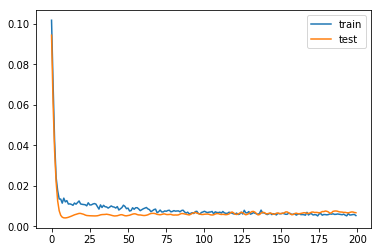

Train: 0.004, Test: 0.007


In [147]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#model.add(Dense(25, activation='linear'))
model.add(Dense(1, activation='relu'))
#model.compile(loss='mae', optimizer=optimizer)
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, 
                    epochs=EPOCHS, batch_size=64, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

train_mse = model.evaluate(train_X, train_y, verbose=0)
test_mse = model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# make a prediction
yhat = model.predict(test_X)
yhat[yhat<0] = 0
yhat_train = model.predict(train_X)
yhat_train[yhat_train<0] = 0

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

Test RMSE: 97.613
Actual data:  [855.692 829.251 774.394 633.767 660.446 774.698 820.077 865.067 760.05
 986.796 980.377 970.19 ]
Forecast:  [906.98440822 833.43965686 758.92514241 589.79336736 591.15596669
 636.85949981 678.14017812 708.66068652 755.92636462 834.65857237
 872.88632322 890.23887326]


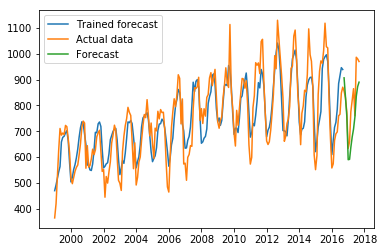

In [148]:
# invert scaling for training
inv_yhat_train = np.concatenate((train_X, yhat_train), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,-1]


# invert scaling for forecast
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print("Actual data: ", inv_y)
print("Forecast: ",inv_yhat)

plt.plot(pd.Series(inv_yhat_train, index=PRODUCTION.index[:-VALIDATION_SHIFT]), label="Trained forecast")
plt.plot(PRODUCTION, label="Actual data")
plt.plot(pd.Series(inv_yhat, index=PRODUCTION.index[-VALIDATION_SHIFT:]), label="Forecast")
plt.legend()